# Music from Spotify
#### SocialGraphs-Project 2022
#### Jan Eberle, Małgorzata Korona, Ellen Mortensen

# Settings

Imports for this notebook

In [1]:
# -*- coding: utf-8 -*-

# for converting of data files
import pandas as pd
import ast
import numpy as np

# communities
#import community.community_louvain as cl

# coloring
from matplotlib import colors as mcolors

# network creation
import networkx as nx
import matplotlib.pyplot as plt

# calculation
from matplotlib.colors import LogNorm

#text
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
from nltk.corpus import stopwords
from collections import Counter
import string
from ast import literal_eval
import re

#!pip install -U gensim
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaMulticore, CoherenceModel
#!python -m pip install -U gensim

import pyLDAvis.gensim_models

#import csv
import math
import seaborn as sns
import os
from tqdm.autonotebook import tqdm
from textwrap import wrap

lemmatizer = WordNetLemmatizer() #initialize the lemmatizer

C:\Users\malgo\anaconda3\lib\site-packages\past\builtins\misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
C:\Users\malgo\anaconda3\lib\site-packages\seaborn\rcmod.py:82: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
C:\Users\malgo\anaconda3\lib\site-packages\setuptools\_distutils\version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
C:\Users\malgo\AppData\Local\Temp\ipykernel_20412\1216352499.py:43: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
import helper # file with functions for network analysis

Set seed for the same ouput all the time

In [3]:
# introduce random seed
import random
seed = 1
random.seed(seed)

Set matplotlib fontsize

In [4]:
plt.rc('xtick', labelsize=12)    # fontsize of the tick labels
plt.rc('ytick', labelsize=12)    # fontsize of the tick labels

# MOOD CALCULATION

We calculated the mood of tracks based on music characteristics. It is calculated based on energy and valence values. There are 4 possible moods: **happy**, **angry**, **calm** and **sad**.

In [5]:
artists = pd.read_csv("artists_data.csv", sep=";")
artists.head()

id       name  number_of_followers  \
0  3TVXtAsR1Inumwj472S9r4      Drake             68477309   
1  0c173mlxpT3dSFRgMO8XPh   Big Sean             10154240   
2  67nwj3Y5sZQLl72VNUHEYE       Wale              3836361   
3  17lzZA2AlOHwCwFALHttmp   2 Chainz              7462599   
4  1sBkRIssrMs1AbVkOJbc7a  Rick Ross              6359211   

                                              genres  popularity  \
0  ['canadian hip hop', 'canadian pop', 'hip hop'...          96   
1  ['detroit hip hop', 'hip hop', 'pop', 'pop rap...          77   
2  ['gangster rap', 'hip hop', 'pop rap', 'r&b', ...          69   
3  ['atl hip hop', 'gangster rap', 'hip hop', 'po...          75   
4  ['dirty south rap', 'gangster rap', 'hip hop',...          76   

                                          top_tracks  
0  [{'album_id': '3cf4iSSKd8ffTncbtKljXw', 'album...  
1  [{'album_id': '2HaqChIDc5go3qxVunBDK0', 'album...  
2  [{'album_id': '0jCVC8ndYYOooEY2YTO1l6', 'album...  
3  [{'album_id': '35KyVKa5AMTaOBxSzjSBbK', 'album...  
4  [{'album_id': '00HZxSA1sOS9T3nA950sg4', 'album...

In [6]:
tracks = pd.read_csv("track_data.csv", sep=";")
tracks.head()

artist_id artist_name  number_of_followers  \
0  3TVXtAsR1Inumwj472S9r4       Drake             68477309   
1  3TVXtAsR1Inumwj472S9r4       Drake             68477309   
2  3TVXtAsR1Inumwj472S9r4       Drake             68477309   
3  3TVXtAsR1Inumwj472S9r4       Drake             68477309   
4  3TVXtAsR1Inumwj472S9r4       Drake             68477309   

                                       artist_genres  artist_popularity  \
0  ['canadian hip hop', 'canadian pop', 'hip hop'...                 96   
1  ['canadian hip hop', 'canadian pop', 'hip hop'...                 96   
2  ['canadian hip hop', 'canadian pop', 'hip hop'...                 96   
3  ['canadian hip hop', 'canadian pop', 'hip hop'...                 96   
4  ['canadian hip hop', 'canadian pop', 'hip hop'...                 96   

                 album_id           album_name album_release_data  \
0  3cf4iSSKd8ffTncbtKljXw  Honestly, Nevermind         2022-06-17   
1  5MS3MvWHJ3lOZPLiMxzOU6             Her Loss         2022-11-04   
2  6tE9Dnp2zInFij4jKssysL    I NEVER LIKED YOU         2022-04-29   
3  5MS3MvWHJ3lOZPLiMxzOU6             Her Loss         2022-11-04   
4  5MS3MvWHJ3lOZPLiMxzOU6             Her Loss         2022-11-04   

   number_of_tracks_on_album                           track_artists  ...  \
0                         14                  ['Drake', '21 Savage']  ...   
1                         16                  ['Drake', '21 Savage']  ...   
2                         16             ['Future', 'Drake', 'Tems']  ...   
3                         16                  ['Drake', '21 Savage']  ...   
4                         16  ['Drake', '21 Savage', 'Travis Scott']  ...   

  valence    tempo  track_lyrics_sentiment_compound  \
0   0.366  165.921                           0.9428   
1   0.424  153.150                          -0.9990   
2   0.339   83.389                           0.4166   
3   0.225  131.016                          -0.9990   
4   0.445  122.030                           0.9901   

   track_lyrics_sentiment_positive  track_lyrics_sentiment_neutral  \
0                            0.132                           0.771   
1                            0.051                           0.738   
2                            0.069                           0.859   
3                            0.137                           0.546   
4                            0.155                           0.745   

   track_lyrics_sentiment_negative  track_name_sentiment_compound  \
0                            0.097                         0.0000   
1                            0.211                         0.5574   
2                            0.071                         0.0000   
3                            0.317                         0.0000   
4                            0.100                         0.0000   

   track_name_sentiment_positive  track_name_sentiment_neutral  \
0                          0.000                         1.000   
1                          0.783                         0.217   
2                          0.000                         1.000   
3                          0.000                         1.000   
4                          0.000                         1.000   

   track_name_sentiment_negative  
0                            0.0  
1                            0.0  
2                            0.0  
3                            0.0  
4                            0.0  

[5 rows x 33 columns]

In [7]:
# function for calculating mood based on energy and valence
def mood(df):
    if df['energy'] >= 0.5:
        if df['valence'] >= 0.5:
            return 'Happy'
        else:
            return 'Angry'
    else:
        if df['valence'] >= 0.5:
            return 'Calm'
        else:
            return 'Sad'
tracks['mood'] = tracks.apply(mood, axis = 1)

Besides mood of tracks, we also assigned a mood for each artist based on the mood that appear most often in their tracks. There are no data about tracks for 2 artists, so it waas impossible to calculate mood for them.

In [8]:
mood_mCommon = []
unique_artists = tracks.artist_name.unique().tolist()
for i in unique_artists:
    mood_list = tracks[tracks.artist_name == i].mood.tolist()
    mood_mCommon.append(max(set(mood_list), key = mood_list.count))

In [9]:
data = {'name': unique_artists, 'mood': mood_mCommon}
artists_mood = pd.DataFrame(data)

In [10]:
artists_wMood = pd.merge(artists, artists_mood, on = 'name', how = 'left')
artists_wMood.head()

id       name  number_of_followers  \
0  3TVXtAsR1Inumwj472S9r4      Drake             68477309   
1  0c173mlxpT3dSFRgMO8XPh   Big Sean             10154240   
2  67nwj3Y5sZQLl72VNUHEYE       Wale              3836361   
3  17lzZA2AlOHwCwFALHttmp   2 Chainz              7462599   
4  1sBkRIssrMs1AbVkOJbc7a  Rick Ross              6359211   

                                              genres  popularity  \
0  ['canadian hip hop', 'canadian pop', 'hip hop'...          96   
1  ['detroit hip hop', 'hip hop', 'pop', 'pop rap...          77   
2  ['gangster rap', 'hip hop', 'pop rap', 'r&b', ...          69   
3  ['atl hip hop', 'gangster rap', 'hip hop', 'po...          75   
4  ['dirty south rap', 'gangster rap', 'hip hop',...          76   

                                          top_tracks   mood  
0  [{'album_id': '3cf4iSSKd8ffTncbtKljXw', 'album...  Angry  
1  [{'album_id': '2HaqChIDc5go3qxVunBDK0', 'album...  Angry  
2  [{'album_id': '0jCVC8ndYYOooEY2YTO1l6', 'album...  Happy  
3  [{'album_id': '35KyVKa5AMTaOBxSzjSBbK', 'album...  Angry  
4  [{'album_id': '00HZxSA1sOS9T3nA950sg4', 'album...  Angry

In [11]:
#save csv
artists_wMood.to_csv("artists_wMood.csv", sep=";", index=False)
tracks.to_csv("tracks_wMood.csv", sep = ";", index = False)

# SENTIMENT CALCULATION

Sentiment was calculated both for lyrics and for track names. We decided to use NLTK VADER model instead of just a basic wordlist with rank assigned to each word. NLTK VADER takes into account not only sentiment of separate words, but also negations, punctuation, degree modifiers, slang (which might be particularly useful for lyrics) etc. NLTK VADER model returns 4 values: positive, neutral and negative, which are only the ratio of a text from each category (so, in other words, how much of a text is positive, neutral and negative), and compound, which takes into account specific rules (regarding grammar and syntax). Compound can be understand as text sentiment intensity, with -1 being extremely negative, 0 - neutral and 1 - extremely positive. (*Hutto, C.J. & Gilbert, E.E. (2014). VADER: A Parsimonious Rule-based Model for Sentiment Analysis of Social Media Text. Eighth International Conference on Weblogs and Social Media (ICWSM-14). Ann Arbor, MI, June 2014.*).

In [12]:
# run if you don't have vader lexicon downloaded
# nltk.download('vader_lexicon')

In [13]:
tracks_df = pd.read_csv("tracks_wMood.csv", sep=";")
tracks_df.head()

artist_id artist_name  number_of_followers  \
0  3TVXtAsR1Inumwj472S9r4       Drake             68477309   
1  3TVXtAsR1Inumwj472S9r4       Drake             68477309   
2  3TVXtAsR1Inumwj472S9r4       Drake             68477309   
3  3TVXtAsR1Inumwj472S9r4       Drake             68477309   
4  3TVXtAsR1Inumwj472S9r4       Drake             68477309   

                                       artist_genres  artist_popularity  \
0  ['canadian hip hop', 'canadian pop', 'hip hop'...                 96   
1  ['canadian hip hop', 'canadian pop', 'hip hop'...                 96   
2  ['canadian hip hop', 'canadian pop', 'hip hop'...                 96   
3  ['canadian hip hop', 'canadian pop', 'hip hop'...                 96   
4  ['canadian hip hop', 'canadian pop', 'hip hop'...                 96   

                 album_id           album_name album_release_data  \
0  3cf4iSSKd8ffTncbtKljXw  Honestly, Nevermind         2022-06-17   
1  5MS3MvWHJ3lOZPLiMxzOU6             Her Loss         2022-11-04   
2  6tE9Dnp2zInFij4jKssysL    I NEVER LIKED YOU         2022-04-29   
3  5MS3MvWHJ3lOZPLiMxzOU6             Her Loss         2022-11-04   
4  5MS3MvWHJ3lOZPLiMxzOU6             Her Loss         2022-11-04   

   number_of_tracks_on_album                           track_artists  ...  \
0                         14                  ['Drake', '21 Savage']  ...   
1                         16                  ['Drake', '21 Savage']  ...   
2                         16             ['Future', 'Drake', 'Tems']  ...   
3                         16                  ['Drake', '21 Savage']  ...   
4                         16  ['Drake', '21 Savage', 'Travis Scott']  ...   

     tempo track_lyrics_sentiment_compound  track_lyrics_sentiment_positive  \
0  165.921                          0.9428                            0.132   
1  153.150                         -0.9990                            0.051   
2   83.389                          0.4166                            0.069   
3  131.016                         -0.9990                            0.137   
4  122.030                          0.9901                            0.155   

   track_lyrics_sentiment_neutral  track_lyrics_sentiment_negative  \
0                           0.771                            0.097   
1                           0.738                            0.211   
2                           0.859                            0.071   
3                           0.546                            0.317   
4                           0.745                            0.100   

   track_name_sentiment_compound  track_name_sentiment_positive  \
0                         0.0000                          0.000   
1                         0.5574                          0.783   
2                         0.0000                          0.000   
3                         0.0000                          0.000   
4                         0.0000                          0.000   

   track_name_sentiment_neutral  track_name_sentiment_negative   mood  
0                         1.000                            0.0  Angry  
1                         0.217                            0.0  Angry  
2                         1.000                            0.0  Angry  
3                         1.000                            0.0  Angry  
4                         1.000                            0.0  Angry  

[5 rows x 34 columns]

In [14]:
tracks_df["track_lyrics_sentiment_compound"] = None
tracks_df["track_lyrics_sentiment_positive"] = None
tracks_df["track_lyrics_sentiment_neutral"] = None
tracks_df["track_lyrics_sentiment_negative"] = None

Sentiment was calculated for all lyrics in English. Although NLTK VADER requires almost none preprocessing, we dicided to remove parts of lyrics that weren't relevant for the text analysis, but were only marking specific parts of songs (such as intro, verse, chorus etc.). Preprocessed lyrics were saved in the dictionary, because they are later used in further parts of text analysis and preprocessed more.

In [15]:
lyrics_directory = "Lyrics_english"
files = os.listdir(lyrics_directory)
lyrics_dict = {}

sid = SentimentIntensityAnalyzer()

for file in tqdm(files, total=len(files)):
    if ".txt" in file:
        index = file.replace(".txt", "")
        with open(lyrics_directory + "/" + file, "r", encoding="utf-8") as f:
            lyrics_text = f.read()
            lyrics_for_sentiment = lyrics_text
            if lyrics_for_sentiment.startswith("Translations"):
                lyrics_for_sentiment = lyrics_for_sentiment.split("\n", 1)[-1]
            lyrics_for_sentiment = re.sub(r'\[enter.*\]', r'', lyrics_for_sentiment, flags=re.IGNORECASE)
            lyrics_for_sentiment = re.sub(r'\[intro.*\]', r'', lyrics_for_sentiment, flags=re.IGNORECASE)
            lyrics_for_sentiment = re.sub(r'\[chorus.*\]', r'', lyrics_for_sentiment, flags=re.IGNORECASE)
            lyrics_for_sentiment = re.sub(r'\[verse.*\]', r'', lyrics_for_sentiment, flags=re.IGNORECASE)
            lyrics_for_sentiment = re.sub(r'\[outro.*\]', r'', lyrics_for_sentiment, flags=re.IGNORECASE)
            lyrics_for_sentiment = re.sub(r'\[pre-chorus.*\]', r'', lyrics_for_sentiment, flags=re.IGNORECASE)
            lyrics_for_sentiment = helper.remove_suffix(lyrics_for_sentiment, 'Embed')
            lyrics_dict[index] = lyrics_for_sentiment #save lyrics in dict

            sent = sid.polarity_scores(lyrics_for_sentiment)
            track_index = int(file.replace(".txt", ""))
            tracks_df["track_lyrics_sentiment_compound"].at[track_index] = sent["compound"]
            tracks_df["track_lyrics_sentiment_positive"].at[track_index] = sent["pos"]
            tracks_df["track_lyrics_sentiment_neutral"].at[track_index] = sent["neu"]
            tracks_df["track_lyrics_sentiment_negative"].at[track_index] = sent["neg"]

  0%|          | 0/17649 [00:00<?, ?it/s]

In [16]:
tracks_df["track_name_sentiment_compound"] = None
tracks_df["track_name_sentiment_positive"] = None
tracks_df["track_name_sentiment_neutral"] = None
tracks_df["track_name_sentiment_negative"] = None

In [17]:
for i, row in tracks_df.iterrows():
    sent = sid.polarity_scores(row["track_name"])
    tracks_df["track_name_sentiment_compound"].at[i] = sent["compound"]
    tracks_df["track_name_sentiment_positive"].at[i] = sent["pos"]
    tracks_df["track_name_sentiment_neutral"].at[i] = sent["neu"]
    tracks_df["track_name_sentiment_negative"].at[i] = sent["neg"]

In [18]:
tracks_df.head()

artist_id artist_name  number_of_followers  \
0  3TVXtAsR1Inumwj472S9r4       Drake             68477309   
1  3TVXtAsR1Inumwj472S9r4       Drake             68477309   
2  3TVXtAsR1Inumwj472S9r4       Drake             68477309   
3  3TVXtAsR1Inumwj472S9r4       Drake             68477309   
4  3TVXtAsR1Inumwj472S9r4       Drake             68477309   

                                       artist_genres  artist_popularity  \
0  ['canadian hip hop', 'canadian pop', 'hip hop'...                 96   
1  ['canadian hip hop', 'canadian pop', 'hip hop'...                 96   
2  ['canadian hip hop', 'canadian pop', 'hip hop'...                 96   
3  ['canadian hip hop', 'canadian pop', 'hip hop'...                 96   
4  ['canadian hip hop', 'canadian pop', 'hip hop'...                 96   

                 album_id           album_name album_release_data  \
0  3cf4iSSKd8ffTncbtKljXw  Honestly, Nevermind         2022-06-17   
1  5MS3MvWHJ3lOZPLiMxzOU6             Her Loss         2022-11-04   
2  6tE9Dnp2zInFij4jKssysL    I NEVER LIKED YOU         2022-04-29   
3  5MS3MvWHJ3lOZPLiMxzOU6             Her Loss         2022-11-04   
4  5MS3MvWHJ3lOZPLiMxzOU6             Her Loss         2022-11-04   

   number_of_tracks_on_album                           track_artists  ...  \
0                         14                  ['Drake', '21 Savage']  ...   
1                         16                  ['Drake', '21 Savage']  ...   
2                         16             ['Future', 'Drake', 'Tems']  ...   
3                         16                  ['Drake', '21 Savage']  ...   
4                         16  ['Drake', '21 Savage', 'Travis Scott']  ...   

     tempo track_lyrics_sentiment_compound  track_lyrics_sentiment_positive  \
0  165.921                          0.9428                            0.132   
1  153.150                          -0.999                            0.051   
2   83.389                          0.4166                            0.069   
3  131.016                          -0.999                            0.137   
4  122.030                          0.9901                            0.155   

   track_lyrics_sentiment_neutral  track_lyrics_sentiment_negative  \
0                           0.771                            0.097   
1                           0.738                            0.211   
2                           0.859                            0.071   
3                           0.546                            0.317   
4                           0.745                              0.1   

   track_name_sentiment_compound  track_name_sentiment_positive  \
0                            0.0                            0.0   
1                         0.5574                          0.783   
2                            0.0                            0.0   
3                            0.0                            0.0   
4                            0.0                            0.0   

   track_name_sentiment_neutral  track_name_sentiment_negative   mood  
0                           1.0                            0.0  Angry  
1                         0.217                            0.0  Angry  
2                           1.0                            0.0  Angry  
3                           1.0                            0.0  Angry  
4                           1.0                            0.0  Angry  

[5 rows x 34 columns]

In [19]:
tracks_df["track_lyrics_sentiment_compound"] = tracks_df["track_lyrics_sentiment_compound"].astype(float)
tracks_df["track_lyrics_sentiment_positive"] = tracks_df["track_lyrics_sentiment_positive"].astype(float)
tracks_df["track_lyrics_sentiment_neutral"] = tracks_df["track_lyrics_sentiment_neutral"].astype(float)
tracks_df["track_lyrics_sentiment_negative"] = tracks_df["track_lyrics_sentiment_negative"].astype(float)

tracks_df["track_name_sentiment_compound"] = tracks_df["track_name_sentiment_compound"].astype(float)
tracks_df["track_name_sentiment_positive"] = tracks_df["track_name_sentiment_positive"].astype(float)
tracks_df["track_name_sentiment_neutral"] = tracks_df["track_name_sentiment_neutral"].astype(float)
tracks_df["track_name_sentiment_negative"] = tracks_df["track_name_sentiment_negative"].astype(float)

For every track with available lyrics and track name sentiment score, pearson correlation coefficient was calculated to check if, for example, songs with positive titles might be and indicator if lyrics are also positive. Pearson correlation coefficient is equal to 0.27, which means that there is a weak correlation between lyrics and track name sentiment. It suggests that when choosing a song to listen to, one should not entirely rely on track name sentiment, because the actual lyrics might have a different sentiment.

In [20]:
pearson_coeff_tracks = tracks_df['track_lyrics_sentiment_compound'].corr(tracks_df['track_name_sentiment_compound'], method="pearson")
print("Pearson correlation coefficient between lyrics sentiment and tracknames sentiment for every artist: {:.2f}". format(pearson_coeff_tracks))

Pearson correlation coefficient between lyrics sentiment and tracknames sentiment for every artist: 0.27


In [21]:
tracks_df.to_csv("track_full_data.csv", sep=";", index=False)

In [22]:
artists_df = pd.read_csv("artists_wMood.csv", sep=";")
artists_df.head()

id       name  number_of_followers  \
0  3TVXtAsR1Inumwj472S9r4      Drake             68477309   
1  0c173mlxpT3dSFRgMO8XPh   Big Sean             10154240   
2  67nwj3Y5sZQLl72VNUHEYE       Wale              3836361   
3  17lzZA2AlOHwCwFALHttmp   2 Chainz              7462599   
4  1sBkRIssrMs1AbVkOJbc7a  Rick Ross              6359211   

                                              genres  popularity  \
0  ['canadian hip hop', 'canadian pop', 'hip hop'...          96   
1  ['detroit hip hop', 'hip hop', 'pop', 'pop rap...          77   
2  ['gangster rap', 'hip hop', 'pop rap', 'r&b', ...          69   
3  ['atl hip hop', 'gangster rap', 'hip hop', 'po...          75   
4  ['dirty south rap', 'gangster rap', 'hip hop',...          76   

                                          top_tracks   mood  
0  [{'album_id': '3cf4iSSKd8ffTncbtKljXw', 'album...  Angry  
1  [{'album_id': '2HaqChIDc5go3qxVunBDK0', 'album...  Angry  
2  [{'album_id': '0jCVC8ndYYOooEY2YTO1l6', 'album...  Happy  
3  [{'album_id': '35KyVKa5AMTaOBxSzjSBbK', 'album...  Angry  
4  [{'album_id': '00HZxSA1sOS9T3nA950sg4', 'album...  Angry

Average lyrics and track name was calculated for all artists with available tracks and lyrics data. Next, the Pearson correlation coefficient was calculated for average track name sentiment and average lyrics sentiment and is equal to 0.39. The correlation is higher than in case of correlation for tracks data, but it's still not a strong correlation. Nevertheless, analyzing track names of artists whole discography might be a better indicator of lyrics sentiment, than only analyzing an individual track.

In [23]:
# average lyrics sentiment for every artist
avg_lyrics_sent_df = tracks_df.groupby("artist_id")["track_lyrics_sentiment_compound"].mean().reset_index().rename(columns={"track_lyrics_sentiment_compound": "avg_lyrics_sentiment"})
artists_df = artists_df.merge(avg_lyrics_sent_df, left_on = "id", right_on = "artist_id", how="left").drop("artist_id", axis=1)

In [24]:
# average trackname sentiment for every artist
avg_lyrics_sent_df = tracks_df.groupby("artist_id")["track_name_sentiment_compound"].mean().reset_index().rename(columns={"track_name_sentiment_compound": "avg_trackname_sentiment"})
artists_df = artists_df.merge(avg_lyrics_sent_df, left_on = "id", right_on = "artist_id", how="left").drop("artist_id", axis=1)

In [25]:
artists_df.head()

id       name  number_of_followers  \
0  3TVXtAsR1Inumwj472S9r4      Drake             68477309   
1  0c173mlxpT3dSFRgMO8XPh   Big Sean             10154240   
2  67nwj3Y5sZQLl72VNUHEYE       Wale              3836361   
3  17lzZA2AlOHwCwFALHttmp   2 Chainz              7462599   
4  1sBkRIssrMs1AbVkOJbc7a  Rick Ross              6359211   

                                              genres  popularity  \
0  ['canadian hip hop', 'canadian pop', 'hip hop'...          96   
1  ['detroit hip hop', 'hip hop', 'pop', 'pop rap...          77   
2  ['gangster rap', 'hip hop', 'pop rap', 'r&b', ...          69   
3  ['atl hip hop', 'gangster rap', 'hip hop', 'po...          75   
4  ['dirty south rap', 'gangster rap', 'hip hop',...          76   

                                          top_tracks   mood  \
0  [{'album_id': '3cf4iSSKd8ffTncbtKljXw', 'album...  Angry   
1  [{'album_id': '2HaqChIDc5go3qxVunBDK0', 'album...  Angry   
2  [{'album_id': '0jCVC8ndYYOooEY2YTO1l6', 'album...  Happy   
3  [{'album_id': '35KyVKa5AMTaOBxSzjSBbK', 'album...  Angry   
4  [{'album_id': '00HZxSA1sOS9T3nA950sg4', 'album...  Angry   

   avg_lyrics_sentiment  avg_trackname_sentiment  
0             -0.281130                  0.09978  
1             -0.272888                  0.17294  
2              0.422171                 -0.03993  
3              0.136000                  0.08388  
4              0.005775                  0.06034

In [26]:
pearson_coeff_artists = artists_df['avg_lyrics_sentiment'].corr(artists_df['avg_trackname_sentiment'], method="pearson")
print("Pearson correlation coefficient between average lyrics sentiment and average tracknames sentiment for every artist: {:.2f}". format(pearson_coeff_artists))

Pearson correlation coefficient between average lyrics sentiment and average tracknames sentiment for every artist: 0.39


In [27]:
artists_df.to_csv("artists_full_data.csv", sep=";")

# NETWORK

## Data preparations

We first load all the whole data we collected so far into this notebook to create in the next steps the network.

In [28]:
# artists data
#artists = pd.read_csv('artists_id.csv', sep=",")
artists_relations = pd.read_csv('artists_relations.csv', sep=";")
artists_data = pd.read_csv('artists_full_data.csv', sep=";")
artists_wMood = pd.read_csv('artists_full_data.csv', sep=";")
# track data
tracks_wMood = pd.read_csv('tracks_wMood.csv', sep=";")

## Define Network nodes and edges

Nodes in our network are artists, with artist's id as a node name. Nodes have following attributes: **name**, **mood**, **avg_lyrics_sentiment**, **popularity** and **genres**, although not every node has every attribute. Two nodes are missing mood attribute, and only 2125 out of 2206 artists have avg_lyrics_sentiment attribute.

In [29]:
nodes = []
for i in range(len(artists_data)):
    nodes = nodes + [artists_data['id'][i]]

In [30]:
# attributes of the nodes
attributes_nodes = {}

for i in nodes:
    name = artists_wMood['name'][artists_wMood.index[artists_wMood['id'] == i]].tolist()[0]
    mood = artists_wMood['mood'][artists_wMood.index[artists_wMood['id'] == i]].tolist()[0]
    avg_lyrics_sentiment = artists_wMood['avg_lyrics_sentiment'][artists_wMood.index[artists_wMood['id'] == i]].tolist()[0]
    popularity = artists_wMood['popularity'][artists_wMood.index[artists_wMood['id'] == i]].tolist()[0]
    genres = artists_wMood['genres'][artists_wMood.index[artists_wMood['id'] == i]].tolist()[0]
    
    attributes_nodes[i] = {"name": name,
                           "mood": mood,
                           "avg_lyrics_sentiment": avg_lyrics_sentiment,
                           "popularity": popularity,
                           "genres": genres,
                          }

We created two networks. In the first one, **graph_related**, there is an edge between two nodes if the artists corresponding to those nodes are related to each other based on Spotify data. In the second network, **graph_colab**, we have the same nodes, but this time two nodes are connected if the artists collaborated with each other. This data was also obtained with Spotify API: every track has a list of artists that were collaborating together in this track.

In [31]:
edges_related = helper.get_edges_artists_relations(artists_relations)

In [32]:
edges_colab = helper.get_edges_artists_colab(artists_data)

**CHECK: Nodes which are in edges but not in the artists data**
In the following two cells we are checking if an node is not mentioned in the artists data.


In [33]:
# check for all artists which are not in artists data
nodes_not_in_data = []

for i in edges_related + edges_colab:
    if not i[0] in artists_data['id'].to_list():
        print("hallo")
        nodes_not_in_data = nodes_not_in_data + [i[0]]
    if not i[1] in artists_data['id'].to_list():
        print(i)
        nodes_not_in_data = nodes_not_in_data + [i[1]]


In [34]:
nodes_not_in_data

[]

## Create Network Graph

### Build Network - Artist(related)

We are creating in the following two cells the **related artist graph** and assign the different attributes to the nodes. Note that we are creating an undirected network without selfloops.

In [35]:
# create graph
graph_related = nx.DiGraph()

# add nodes and edges
graph_related.add_nodes_from(nodes)
graph_related.add_edges_from(edges_related)

# add attributes
nx.set_node_attributes(graph_related, attributes_nodes)

# remove isolated
#graph_related.remove_nodes_from(list(nx.isolates(graph_related)))

In [36]:
# convert to undirected
graph_related = graph_related.to_undirected()
# remove selfloops
graph_related.remove_edges_from(nx.selfloop_edges(graph_related))

### Build Network - Artist(colab)

We are creating in the following two cells the **collaboration artist graph** and assign the different attributes to the nodes. 
Note that we are creating an undirected network without selfloops. 
Note that we are creating two graphs: one for the visualization with the not connected nodes and one without for the calculations.

In [37]:
# create graph
graph_colab = nx.DiGraph()
graph_colab_calc = nx.DiGraph()

# graph_colab used only for drawing seeing all nodes which are also in related network with the same positions calculated
graph_colab.add_nodes_from(nodes)
graph_colab.add_edges_from(edges_colab)
nx.set_node_attributes(graph_colab, attributes_nodes)

# graph_colab_calc used for calculations - isolated nodes are removed in this case
graph_colab_calc.add_nodes_from(nodes)
graph_colab_calc.add_edges_from(edges_colab)
nx.set_node_attributes(graph_colab_calc, attributes_nodes)

# remove isolated
graph_colab_calc.remove_nodes_from(list(nx.isolates(graph_colab_calc)))

In [38]:
# convert to undirected and remove selfloops
graph_colab = graph_colab.to_undirected()
graph_colab.remove_edges_from(nx.selfloop_edges(graph_colab))

graph_colab_calc = graph_colab_calc.to_undirected()
graph_colab_calc.remove_edges_from(nx.selfloop_edges(graph_colab_calc))

In [39]:
# remove the nodes without edges from our graph: graph_colab_calc so they are not involved in the calculation
for i in list(graph_colab_calc.nodes()):
    if graph_colab_calc.degree(i) == 0:
        graph_colab_calc.remove_node(i)

## Draw Network Graphs

We calculated the position of nodes for graph_related and then used it once again for graph_colab, so that both graphs have the same positions of nodes and are easy to compare. 

In [40]:
positions = helper.calculate_position(graph_related)

C:\Users\malgo\anaconda3\lib\site-packages\fa2\forceatlas2.py:240: DeprecationWarning: 

The scipy.sparse array containers will be used instead of matrices
in Networkx 3.0. Use `to_scipy_sparse_array` instead.
  M = networkx.to_scipy_sparse_matrix(G, dtype='f', format='lil')
100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:01<00:00, 32.54it/s]

BarnesHut Approximation  took  21.07  seconds
Repulsion forces  took  37.76  seconds
Gravitational forces  took  0.22  seconds
Attraction forces  took  0.14  seconds
AdjustSpeedAndApplyForces step  took  0.97  seconds


**Graph with edges_related**

In [41]:
# get color map and size map for following networks
color_map_popularity = helper.calculate_color_map_popularity(graph_related, artists_data)
size_map_degree = helper.calculate_node_size_map_degree(graph_related)

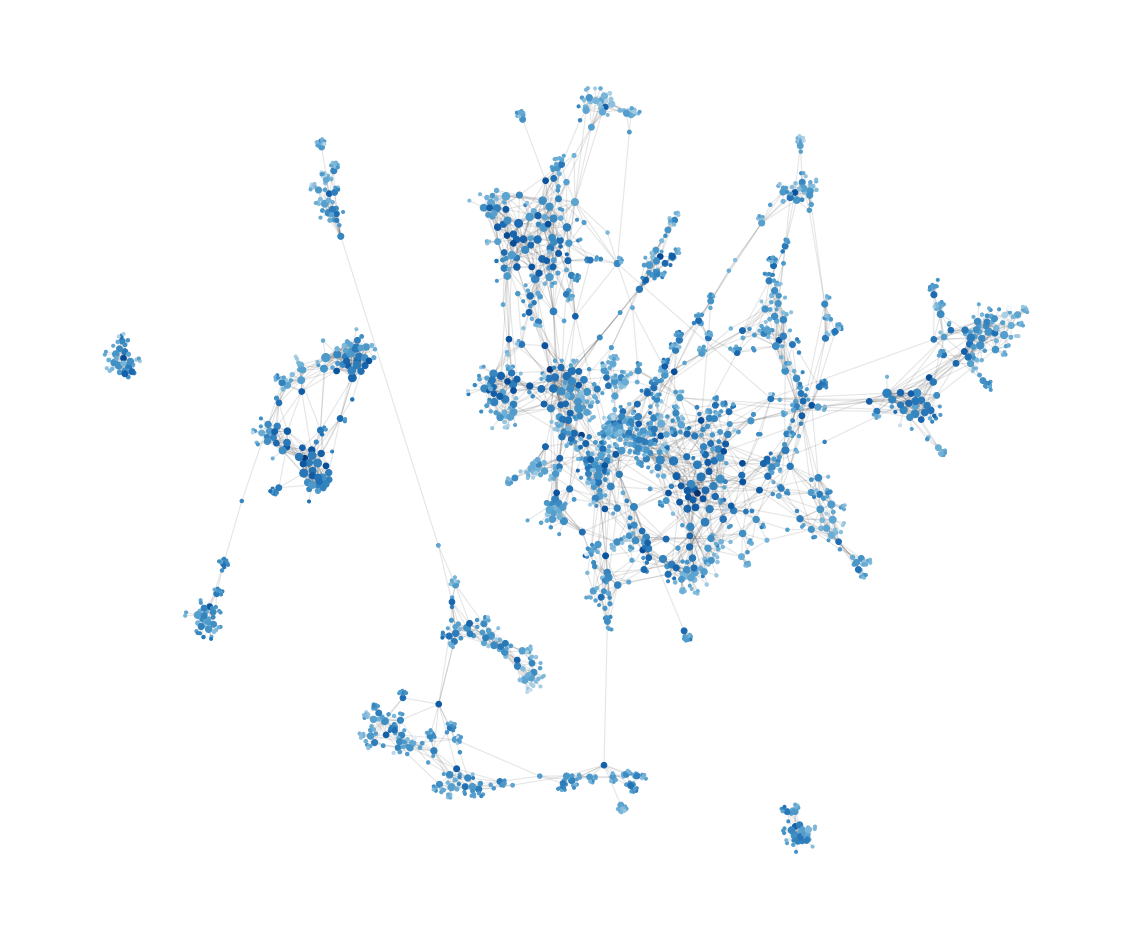

In [42]:
helper.draw_network(graph_related, positions,
            alpha_nodes=1, color_map_nodes=color_map_popularity, node_size=size_map_degree)

The graph above shows network with **edges_related**, so the one where edges are based on relations between artists. Nodes color indicates artist's popularity, with dark blue being more popular, and light blue being less popular, whereas nodes size correponds to degree. It's worth noticing that the right part of a network is higly connected, creating a separate component with only a bridge to smaller components. On the left side of a network nodes form a few smaller clusters. These clusters might be formed because of the way the network was created - the most popular artists were connected to 10 related artists, and then every related artist was also connected to another 10 related artists. Because of that, popular artists might become a central point of such clusters, with the related artists put around them. There are also two small separate clusters visible.

**Graph with edges_colab**

In [43]:
# get color map and size map for following networks
color_map_popularity = helper.calculate_color_map_popularity(graph_colab, artists_data)
size_map_degree = helper.calculate_node_size_map_degree(graph_colab)

In [44]:
# get alpha map
# leave out nodes which do not have a degree cause of missing data problem
alpha_degree = helper.calculate_alpha_degree(graph_colab)

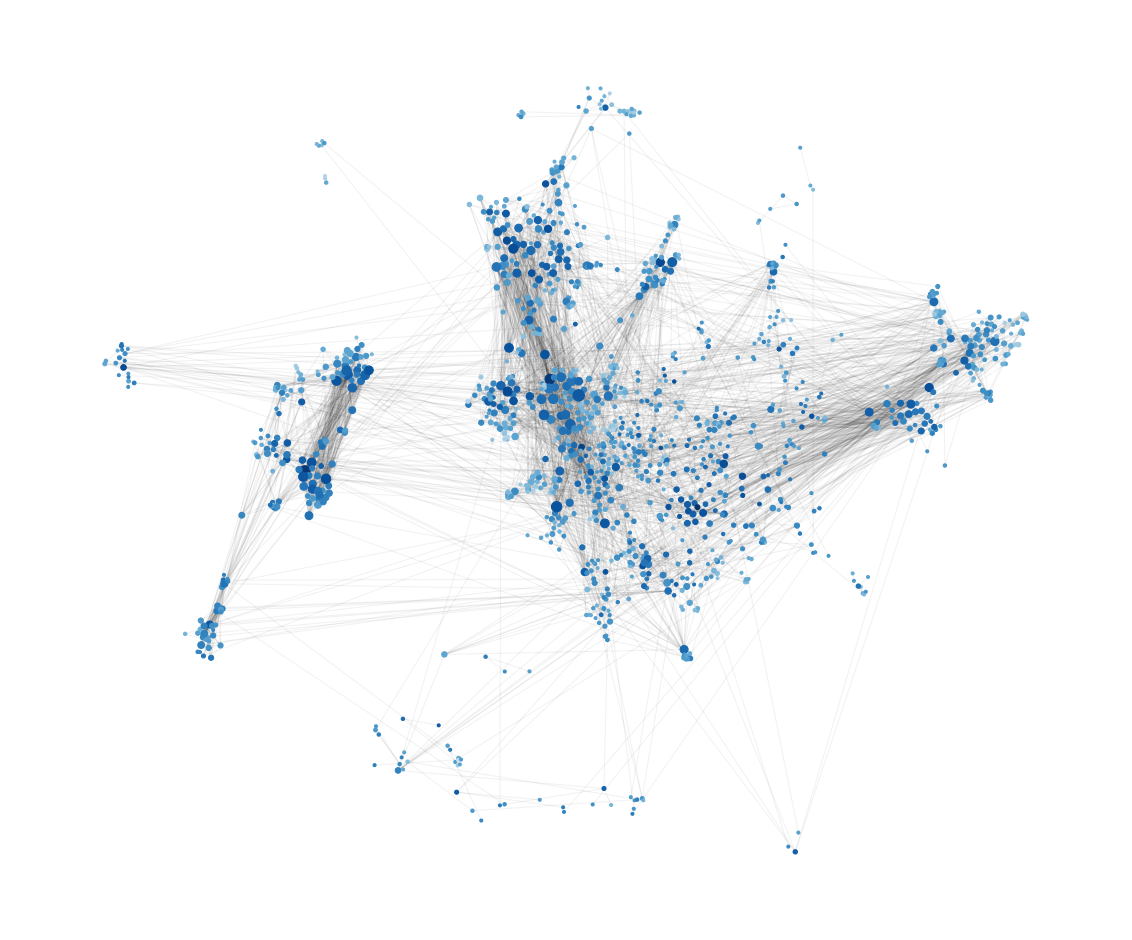

In [45]:
helper.draw_network(graph_colab, positions,
             alpha_nodes=alpha_degree, color_map_nodes=color_map_popularity, node_size=size_map_degree,
            alpha_edges=0.05)

The graph above shows network with **edges_colab**. In this case there were isolated nodes, which are not shown in the graph. The edges are more evenly distributed, without creating separate clusters, but when comparing the two graphs it's visible that for some clusters from graph_related nodes in graph_colab have more edges that with other parts of the graph. As we now that common fans are one of the feature of how related artists in Spotify are calculated, we can suspect that people are more likely to be fans of artists who collaborate together.

# Graph Analysis

In this section we are analysing our network. We are considering different factors as well as communities.

## Network

***Nodes***

In [46]:
print("Graph amount of nodes(related): " + str(len(graph_related.nodes())))
print("Graph amount of nodes(colab): " + str(len(graph_colab_calc.nodes())))

Graph amount of nodes(related): 2206
Graph amount of nodes(colab): 1296


The number of nodes in both graphs differ. This is because in graph_related there are no isolated nodes, so the amount of nodes is the same as the number of artists we originally downloaded from Spotify API, and in graph_colab we removed all isolated nodes, i.e. artists that didn't collaborate with anyone from a list of downloaded artists.

***Edges***

In [47]:
print("Graph amount of edges (related edges): " + str(len(graph_related.edges())))
print("Graph amount of edges (colaborating edges): " + str(len(graph_colab_calc.edges())))

Graph amount of edges (related edges): 5613
Graph amount of edges (colaborating edges): 3624


Number of edges in graph_related is equal to 5613, whereas number of edges in graph_colab it's 3624. Since the graph_colab has almost 1000 less nodes, because not all artists from the list of downloaded artists collaborated with others, it's also not unusual that it has a smaller number of edges.

***Degree statistics***

In [48]:
graph_related_stats = helper.get_degree_stats(graph_related)
print("Mean of degree for graph_related: {}".format(graph_related_stats["mean"]))
print("Median of degree for graph_related: {}".format(graph_related_stats["median"]))
print("Mode of degree for graph_related: {}".format(graph_related_stats["mode"]))
print("Min of degree for graph_related: {}".format(graph_related_stats["min"]))
print("Max of degree for graph_related: {}".format(graph_related_stats["max"]))

Mean of degree for graph_related: 5.088848594741614
Median of degree for graph_related: 2.0
Mode of degree for graph_related: ModeResult(mode=array([1]), count=array([907]))
Min of degree for graph_related: 1
Max of degree for graph_related: 26


C:\Users\malgo\Documents\DTU\02805 Social graphs and interactions\project\spotify\helper.py:532: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode_ = mode(degree_sequence)


In [49]:
graph_colab_stats = helper.get_degree_stats(graph_colab_calc)
print("Mean of degree for graph_colab: {}".format(graph_colab_stats["mean"]))
print("Median of degree for graph_colab: {}".format(graph_colab_stats["median"]))
print("Mode of degree for graph_colab: {}".format(graph_colab_stats["mode"]))
print("Min of degree for graph_colab: {}".format(graph_colab_stats["min"]))
print("Max of degree for graph_colab: {}".format(graph_colab_stats["max"]))

Mean of degree for graph_colab: 5.592592592592593
Median of degree for graph_colab: 3.0
Mode of degree for graph_colab: ModeResult(mode=array([1]), count=array([314]))
Min of degree for graph_colab: 1
Max of degree for graph_colab: 49


***Most connected artists***

In [50]:
n = 5
print("Top {} most connected artists in graph with edges_related".format(n))
helper.get_most_connected_artists(graph_related, artists_data, n)

Top 5 most connected artists in graph with edges_related
Name: Trebol Clan, degree: 26
Name: Cheat Codes, degree: 25
Name: Young Money, degree: 25
Name: Dalmata, degree: 24
Name: Zion, degree: 24


In [51]:
n = 5
print("Top {} most connected artists in graph with edges_colab".format(n))
helper.get_most_connected_artists(graph_colab_calc, artists_data, n)

Top 5 most connected artists in graph with edges_colab
Name: Lil Wayne, degree: 49
Name: Bad Bunny, degree: 43
Name: Chris Brown, degree: 40
Name: Drake, degree: 36
Name: Ty Dolla $ign, degree: 35


In our colaboration network we have an match between the 100 most popular artists and the 5 most connected artists. However in our related network we do not have a match between the 100 most popular artists and the 5 most connected artists. 

### Centrality

We calculated degree centrality, betweenness centrality and eigenvector centrality for both graphs.

***Degree centrality***

Of course, degree centrality is perfectly correlated with nodes degrees and therefore the results are the same as in lists of most connected artists. Nevertheless, degree centrality was calculated to check correlation with betweeness centrality and eigenvector centrality.

In [52]:
n = 5
centrality_type = "degree_centrality"
degree_centrality_related = helper.calculate_centrality(graph_related, centrality_type)
degree_centrality_colab = helper.calculate_centrality(graph_colab_calc, centrality_type)

In [53]:
print("Top {} most central artists in graph with edges_related according to {}".format(n, centrality_type))
helper.get_most_central_artist(graph_related, artists_data, degree_centrality_related, n, centrality_type)

Top 5 most central artists in graph with edges_related according to degree_centrality
Name: Trebol Clan, degree centrality: 0.011791383219954649
Name: Cheat Codes, degree centrality: 0.011337868480725623
Name: Young Money, degree centrality: 0.011337868480725623
Name: Dalmata, degree centrality: 0.0108843537414966
Name: Zion, degree centrality: 0.0108843537414966


For graph_related, most central artists based on degree centrality are Trebol Clan, Cheat Codes, Young Money, Dalmata and Zion. It's interesting to see that, contrary to intuition, artists with highest degrees aren't amongst most streamed artists. It may suggest that those artists are in some ways similar to many other artists, whereas most streamed artists have some kind of unique characteristics, because of which they aren't related to  a lot of other singers.

In [54]:
print("Top {} most central artists in graph with edges_colab according to {}".format(n, centrality_type))
helper.get_most_central_artist(graph_colab_calc, artists_data, degree_centrality_colab, n, centrality_type)

Top 5 most central artists in graph with edges_colab according to degree_centrality
Name: Lil Wayne, degree centrality: 0.03783783783783784
Name: Bad Bunny, degree centrality: 0.033204633204633204
Name: Chris Brown, degree centrality: 0.03088803088803089
Name: Drake, degree centrality: 0.027799227799227798
Name: Ty Dolla $ign, degree centrality: 0.02702702702702703


For graph_colab, most central nodes based on degree centrality are Lil Wayne, Bad Bunny, Chris Brown, Drake and Ty Dolla $ign. They not only are amongst the most streamed artists, but they also (besides Chris Brown) represent the same genre - rap. It suggests that rappers collaborate with artists more often than other singers.

***Betweenness centrality***

Betweenness centrality, in simple words, is a measure of on how many shortests paths in the graph nodes. The more shortests paths a node is a part of, the highest its centrality is going to be.

In [55]:
n = 5
centrality_type = "betweenness_centrality"
betweenness_centrality_related = helper.calculate_centrality(graph_related, centrality_type)
betweenness_centrality_colab = helper.calculate_centrality(graph_colab_calc, centrality_type)

In [56]:
print("Top {} most central artists in graph with edges_related according to {}".format(n, centrality_type))
helper.get_most_central_artist(graph_related, artists_data, betweenness_centrality_related, n, centrality_type)

Top 5 most central artists in graph with edges_related according to betweenness_centrality
Name: Michael Jackson, betweenness centrality: 0.2493785578454016
Name: Janet Jackson, betweenness centrality: 0.2458070127823575
Name: Paul Young, betweenness centrality: 0.18254637850057617
Name: Freddie Mercury, betweenness centrality: 0.1713079116114868
Name: Queen, betweenness centrality: 0.13654103443101345


When it comes to betweenness centrality for graph_related, the most central artists (Michael Jackson, Janet Jackson, Paul Young, Freddie Mercury and Queen) are, as one could say, the most important artists of all time. It means that although they don't have high degree centrality, they are "members" of many shortests path in the graph. It might indicate that even though they aren't directly related to many other singers, the could have been an inspiration and influenced work of many people.

In [57]:
print("Top {} most central artists in graph with edges_colab according to {}".format(n, centrality_type))
helper.get_most_central_artist(graph_colab_calc, artists_data, betweenness_centrality_colab, n, centrality_type)

Top 5 most central artists in graph with edges_colab according to betweenness_centrality
Name: Lil Wayne, betweenness centrality: 0.04902897847208152
Name: David Guetta, betweenness centrality: 0.038924700658022886
Name: J Balvin, betweenness centrality: 0.037389273371232955
Name: Chris Brown, betweenness centrality: 0.036817350877865855
Name: Snoop Dogg, betweenness centrality: 0.03317234912752879


For graph_colab we got similar results regarding betweenness centrality as degree centrality. Most central artists in this case (Lil Wayne, David Guetta, J Balvin, Chris Brown, Snoop Dogg) are also amongst most popular ones, and some of them appear in both cases. It seems intuitive that when artist collaborate a lot with other people, then he or she will be a part of many shortest paths.

***Eigenvector centrality***

Eigenvector centrality is based on how many high degree nodes lead to a certain node. So, if a node has a lot of neighbours with high degree, its centrality is going to be higher than for a node with low degree neighbours.

In [58]:
n = 5
centrality_type = "eigenvector_centrality"
eigenvector_centrality_related = helper.calculate_centrality(graph_related, centrality_type)
eigenvector_centrality_colab = helper.calculate_centrality(graph_colab_calc, centrality_type)

In [59]:
print("Top {} most central artists in graph with edges_related according to {}".format(n, centrality_type))
helper.get_most_central_artist(graph_related, artists_data, eigenvector_centrality_related, n, centrality_type)

Top 5 most central artists in graph with edges_related according to eigenvector_centrality
Name: Trebol Clan, eigenvector centrality: 0.2939513416694297
Name: Zion, eigenvector centrality: 0.2668572815065759
Name: De La Ghetto, eigenvector centrality: 0.2551312462911472
Name: Jowell & Randy, eigenvector centrality: 0.2457624254141686
Name: DJ Nelson, eigenvector centrality: 0.23884092522374992


Most central artists based on eigenvector centrality for graph_related are Trebol Clan, Zion, De La Ghetto, Jowell & Randy and DJ Nelson. Some artists are the same as in case of degree centrality, and they also can't be considered as most streamed ones. The centrality in this case means that many high degree nodes lead to those central nodes. Again, since these artists are mostly connected to other artists with high degrees, it might suggest that they don't have any unique characteristics, but have a mixture of characteristics specific to other artists.

In [60]:
print("Top {} most central artists in graph with edges_colab according to {}".format(n, centrality_type))
helper.get_most_central_artist(graph_colab_calc, artists_data, eigenvector_centrality_colab, n, centrality_type)

Top 5 most central artists in graph with edges_colab according to eigenvector_centrality
Name: Bad Bunny, eigenvector centrality: 0.2992608741684879
Name: Anuel AA, eigenvector centrality: 0.2221521845573407
Name: Arcangel, eigenvector centrality: 0.21744202753256137
Name: Ozuna, eigenvector centrality: 0.21159394576086119
Name: Farruko, eigenvector centrality: 0.2023986781492913


Finally, the results for eigenvector centrality in case of graph_colab are quite different than for degree centrality and betweenness centrality. This time most of the most central artists (Bad Bunny, Anuel AA, Arcangel, Ozuna, Farruko) are not streamed so often. Their neighbours are usually nodes with high degrees. Since this is the graph where edges are based on collaboration, it's not unusual that most central nodes aren't those who actually have high degrees, because the fact that someone collaborates with others a lot doesn't mean that he or she makes tracks with people who also collaborate with others a lot.

***Cenralities correlations***

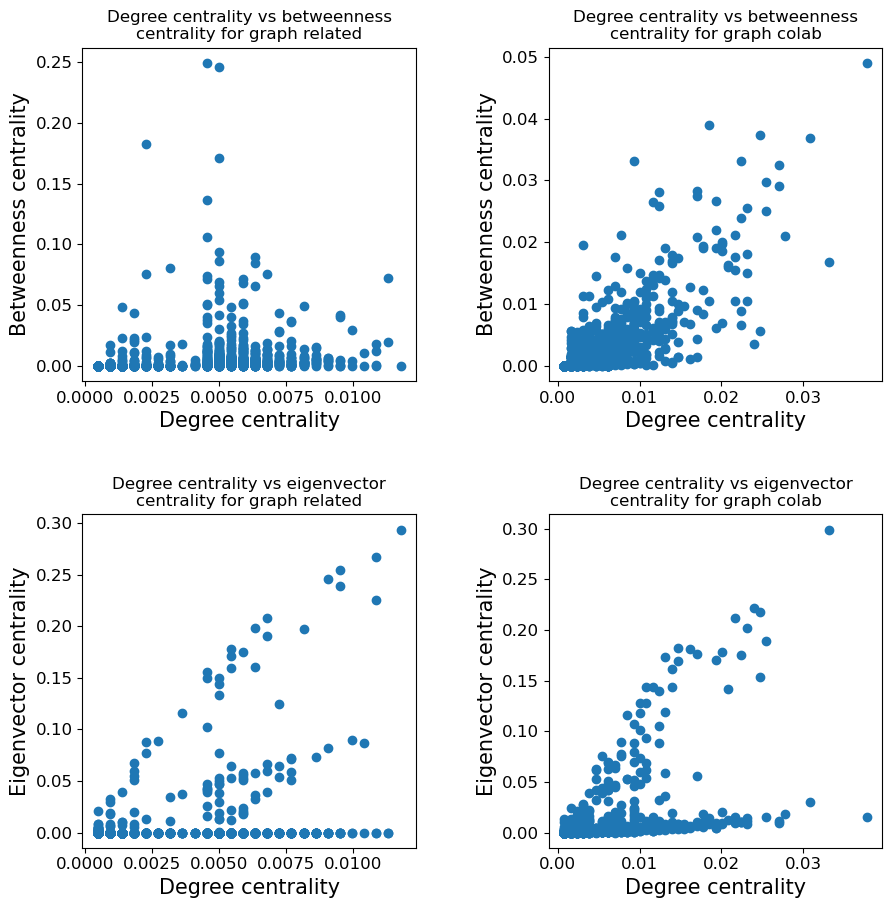

In [61]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10)) #, constrained_layout=False)
#fig.subplots_adjust(hspace=.3)
fig.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)

axs[0, 0].scatter([i[0] for i in degree_centrality_related], [i[0] for i in betweenness_centrality_related])
axs[0, 0].set_xlabel("Degree centrality", fontsize=15)
axs[0, 0].set_ylabel("Betweenness centrality", fontsize=15)
axs[0, 0].set_title("\n".join(wrap("Degree centrality vs betweenness centrality for graph related", 40)))
axs[0, 1].scatter([i[0] for i in degree_centrality_colab], [i[0] for i in betweenness_centrality_colab])
axs[0, 1].set_xlabel("Degree centrality", fontsize=15)
axs[0, 1].set_ylabel("Betweenness centrality", fontsize=15)
axs[0, 1].set_title("\n".join(wrap("Degree centrality vs betweenness centrality for graph colab", 40)))
axs[1, 0].scatter([i[0] for i in degree_centrality_related], [i[0] for i in eigenvector_centrality_related])
axs[1, 0].set_xlabel("Degree centrality", fontsize=15)
axs[1, 0].set_ylabel("Eigenvector centrality", fontsize=15)
axs[1, 0].set_title("\n".join(wrap("Degree centrality vs eigenvector centrality for graph related", 40)))
axs[1, 1].scatter([i[0] for i in degree_centrality_colab], [i[0] for i in eigenvector_centrality_colab])
axs[1, 1].set_xlabel("Degree centrality", fontsize=15)
axs[1, 1].set_ylabel("Eigenvector centrality", fontsize=15)
axs[1, 1].set_title("\n".join(wrap("Degree centrality vs eigenvector centrality for graph colab", 40)))
plt.show()

The graphs above show relations between degree centrality and betweenness centrality or eigenvector centrality for both graphs.

It's clearly visible that there is no correlation between degree centrality and betweenness centrality for graph_related. It corresponds to the lists of 5 most central artists, which were different in both cases.

As for graph_colab, there is a clear correlation between betweenness centrality and degree centrality. It agrees with the results of the most central artists - similar artists were in both lists. The nature of this relationship also corresponds to the structure of the network - it's rather tidy and neat, without any particularly unusual structures.

In case of graph_related, there is some correlation between eigenvector centrality and degree centrality, but it's also worth noticing that in the whole range of degree centrality there are many nodes with egienvector centrality close or equal to zero. It corresponds to the results obtained earlier - there are some artists that have both high degree centrality and high eigenvector centrality, but at the same time there are artists with high eigenvector centrality and low degree centrality, and vice versa.

Similarly to graph_related, there is some correlation visible between eigenvector centrality and degree centrality for graph_colab, but there are also many observations in the whole range of degree centrality that have eigenvector centrality close to zero. The correlation in this case is less obvious than in case of degree centrality and betweenness centrality, which is also visible in the lists of most central artists.

***Clustering coefficient***

In [62]:
# whole graph
clustering_graph_related = nx.average_clustering(graph_related)
clustering_graph_colab = nx.average_clustering(graph_colab_calc)

print("clustering coefficient (related edges): " + str(clustering_graph_related))
print("clustering coefficient (colaborating edges): " + str(clustering_graph_colab))

clustering coefficient (related edges): 0.26695709016586766
clustering coefficient (colaborating edges): 0.14359996250511145


The clustering coefficient shows to what degree the nodes tend to cluster together. For both graphs the value is positiv. But the value for the related graph is almost twice as high as for the collaboration graph. 

***Assortativity coefficient***

In [63]:
assortativity_graph_related = nx.degree_assortativity_coefficient(graph_related)
assortativity_graph_colab = nx.degree_assortativity_coefficient(graph_colab_calc)

print("Assortativity coefficient (related edges): " + str(assortativity_graph_related))
print("Assortativity coefficient (colaborating edges): " + str(assortativity_graph_colab))

Assortativity coefficient (related edges): -0.14668890689950587
Assortativity coefficient (colaborating edges): 0.13937770211549994


The assortativity coefficient shows with which possibility the nodes tend to connect with other nodes of the same degree. For the related graph the value is negativ which means the nodes tend to connect with other nodes which have a different degree. For the collaboration graph the value is positiv, which means the nodes tend to connect to nodes which have a similar degree.

In [64]:
# Assortativity on attributes
# mood
assortativity_graph_related_mood = nx.attribute_assortativity_coefficient(graph_related, "mood")
assortativity_graph_colab_mood = nx.attribute_assortativity_coefficient(graph_colab_calc, "mood")
print("Assortativity coefficient on mood (related edges): " + str(assortativity_graph_related_mood))
print("Assortativity coefficient on mood (colab edges): " + str(assortativity_graph_colab_mood))

# avg_lyrics_sentiment
assortativity_graph_related_sentiment = nx.attribute_assortativity_coefficient(graph_related, "avg_lyrics_sentiment")
assortativity_graph_colab_sentiment = nx.attribute_assortativity_coefficient(graph_colab_calc, "avg_lyrics_sentiment")
print("Assortativity coefficient on avg_lyrics_sentiment (related edges): " + str(assortativity_graph_related_sentiment))
print("Assortativity coefficient on avg_lyrics_sentiment (colab edges): " + str(assortativity_graph_colab_sentiment))

# popularity
assortativity_graph_related_populartity = nx.attribute_assortativity_coefficient(graph_related, "popularity")
assortativity_graph_colab_populartity = nx.attribute_assortativity_coefficient(graph_colab_calc, "popularity")
print("Assortativity coefficient on popularity (related edges): " + str(assortativity_graph_related_populartity))
print("Assortativity coefficient on popularity (colab edges): " + str(assortativity_graph_colab_populartity))

Assortativity coefficient on mood (related edges): 0.27841507529340154
Assortativity coefficient on mood (colab edges): 0.16328850344831974
Assortativity coefficient on avg_lyrics_sentiment (related edges): -0.0009721313348861569
Assortativity coefficient on avg_lyrics_sentiment (colab edges): -0.0017031058504750158
Assortativity coefficient on popularity (related edges): -0.002034610531187888
Assortativity coefficient on popularity (colab edges): -0.0003530760660589086


We can also calculate the assortativity coefficient for other attributes than the degree of a node. 

If we take a look at the **mood** of a node we can see, that nodes tend to connect with other nodes with the same mood. This is true for both networks, but the coefficient is again almost twice as high for the related network as it is for the collaboration network.

For the **average lyrics sentiment** and the **popularity** of the nodes we get values which are close to zero for both networks. This means that the nodes do not tend to connect to either different or same nodes. There is no correlation.

## Plot Graph Attributes

### Heatmaps
Here we are plotting different attributes against each other in heatmaps

**Popularity vs. Node degree**

In [186]:
nodes = [i for i in graph_related.nodes()]

# x-axis and y-axis
x_axis_related = sorted([graph_related.degree(i) for i in nodes])
y_axis_related = [artists_data['popularity'][artists_data.index[artists_data['id'] == i]].tolist()[0] for i in nodes]

In [187]:
nodes = [i for i in graph_colab_calc.nodes()]

# x-axis and y-axis
x_axis_colab = sorted([graph_colab_calc.degree(i) for i in nodes])
y_axis_colab = [artists_data['popularity'][artists_data.index[artists_data['id'] == i]].tolist()[0] for i in nodes]

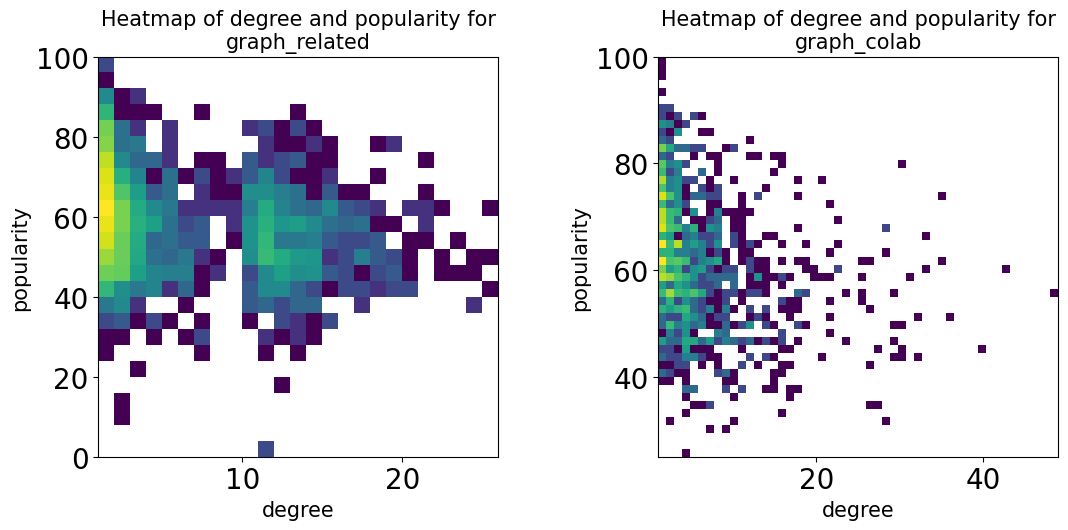

In [191]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5)) #, constrained_layout=False)
fig.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)

heatmap, extent = helper.get_heat_map(x_axis_related, y_axis_related, bin_size=25)
axs[0].imshow(heatmap.T, extent=extent, origin='lower',
               norm=LogNorm(), aspect='auto')
axs[0].set_title("\n".join(wrap("Heatmap of degree and popularity for graph_related", 40)), fontsize=15)
axs[0].set_xlabel("degree", fontsize=15)
axs[0].set_ylabel("popularity", fontsize=15)
#axs[0].colorbar()

heatmap, extent = helper.get_heat_map(x_axis_colab, y_axis_colab, bin_size=50)
axs[1].imshow(heatmap.T, extent=extent, origin='lower',
               norm=LogNorm(), aspect='auto')
axs[1].set_title("\n".join(wrap("Heatmap of degree and popularity for graph_colab", 40)), fontsize=15)
axs[1].set_xlabel("degree", fontsize=15)
axs[1].set_ylabel("popularity", fontsize=15)

plt.show()

The heatmaps show the relation between the popularity and the degree of the nodes. 
For both graphs the result seems pretty similar. We have a similar shape starting with a full range of popularity on the y-axis for the lower degree nodes. And then tapers to the middle values range of the popularity axis and getting less with increasing node degree.
The most nodes with the highest popularity tend to have a lower degree. A higher node degree does not indicate a more popular value. The main range seems to be between 20 and 80 popularity. Adding more data would probably lead to a more dense peak in x-direction.


**Sentiment vs. Node degree**

In [192]:
# related
nodes = []
for i in list(graph_related):
    if i in artists_wMood['id'].tolist():
        nodes.append(i)
        
# x-axis and y-axis
x_axis_related = sorted([graph_related.degree(i) for i in nodes])
y_axis_related = [artists_wMood['avg_lyrics_sentiment'][artists_wMood.index[artists_wMood['id'] == i]].tolist()[0] for i in nodes]

In [193]:
# colab
nodes = []
for i in list(graph_colab_calc):
    if i in artists_wMood['id'].tolist():
        nodes.append(i)
        
# x-axis and y-axis
x_axis_colab = sorted([graph_colab_calc.degree(i) for i in nodes])
y_axis_colab = [artists_wMood['avg_lyrics_sentiment'][artists_wMood.index[artists_wMood['id'] == i]].tolist()[0] for i in nodes]

In [194]:
# get rid of the NaN values (related)
filtered = []
for i in range(len(y_axis_related)):
    if not math.isnan(y_axis_related[i]):
        filtered.append(y_axis_related[i])
    else:
        # delete coresponding x_axis value
        del x_axis_related[i]
        
y_axis_related = filtered

In [195]:
# get rid of the NaN values (colab)
filtered = []
for i in range(len(y_axis_colab)):
    if not math.isnan(y_axis_colab[i]):
        filtered.append(y_axis_colab[i])
    else:
        # delete coresponding x_axis value
        del x_axis_colab[i]
        
y_axis_colab = filtered

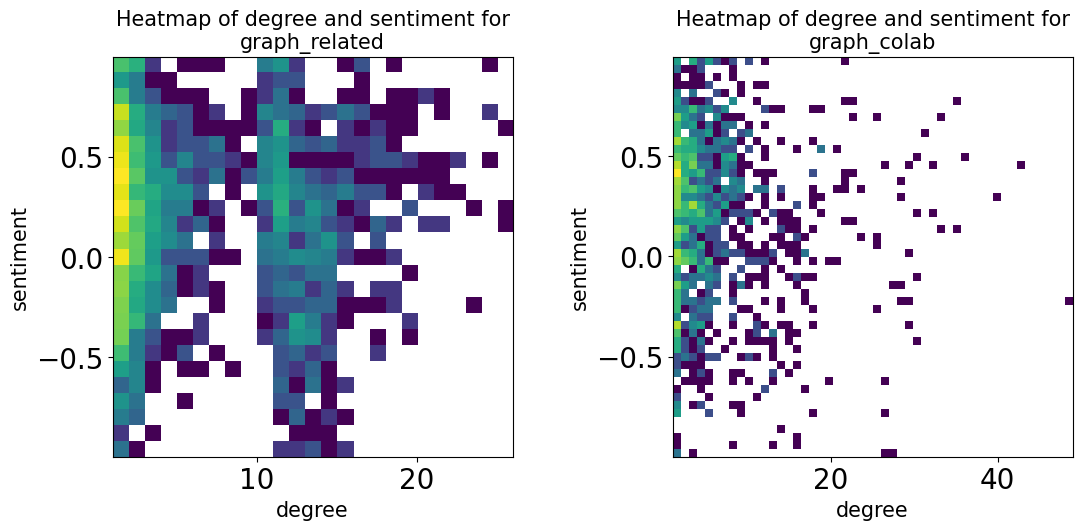

In [196]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5)) #, constrained_layout=False)
fig.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)

heatmap, extent = helper.get_heat_map(x_axis_related, y_axis_related, bin_size=25)
axs[0].imshow(heatmap.T, extent=extent, origin='lower',
               norm=LogNorm(), aspect='auto')
axs[0].set_title("\n".join(wrap("Heatmap of degree and sentiment for graph_related", 40)), fontsize=15)
axs[0].set_xlabel("degree", fontsize=15)
axs[0].set_ylabel("sentiment", fontsize=15)

heatmap, extent = helper.get_heat_map(x_axis_colab, y_axis_colab, bin_size=50)
axs[1].imshow(heatmap.T, extent=extent, origin='lower',
               norm=LogNorm(), aspect='auto')
axs[1].set_title("\n".join(wrap("Heatmap of degree and sentiment for graph_colab", 40)), fontsize=15)
axs[1].set_xlabel("degree", fontsize=15)
axs[1].set_ylabel("sentiment", fontsize=15)
plt.show()

We see the heatmap comparing the sentiment of the node with the degree of the node. Again both graphs have a similar shape. There seems to be no real correlation between the sentiment and the degree of a node.

**Sentiment vs. Popularity**

In [197]:
#related
# x-axis and y-axis
nodes = [i for i in graph_related.nodes()]
x_axis_related = [artists_data['popularity'][artists_data.index[artists_data['id'] == i]].tolist()[0] for i in nodes]
y_axis_related = [artists_wMood['avg_lyrics_sentiment'][artists_wMood.index[artists_wMood['id'] == i]].tolist()[0] for i in nodes]

In [198]:
# colab
# x-axis and y-axis
nodes = [i for i in graph_colab_calc.nodes()]
x_axis_colab = [artists_data['popularity'][artists_data.index[artists_data['id'] == i]].tolist()[0] for i in nodes]
y_axis_colab = [artists_wMood['avg_lyrics_sentiment'][artists_wMood.index[artists_wMood['id'] == i]].tolist()[0] for i in nodes]

In [199]:
# get rid of the NaN values (related)
filtered = []
for i in range(len(y_axis_related)):
    if not math.isnan(y_axis_related[i]):
        filtered.append(y_axis_related[i])
    else:
        # delete coresponding x_axis value
        del x_axis_related[i]
        
y_axis_related = filtered

In [200]:
# get rid of the NaN values (colab)
filtered = []
for i in range(len(y_axis_colab)):
    if not math.isnan(y_axis_colab[i]):
        filtered.append(y_axis_colab[i])
    else:
        # delete coresponding x_axis value
        del x_axis_colab[i]
        
y_axis_colab = filtered

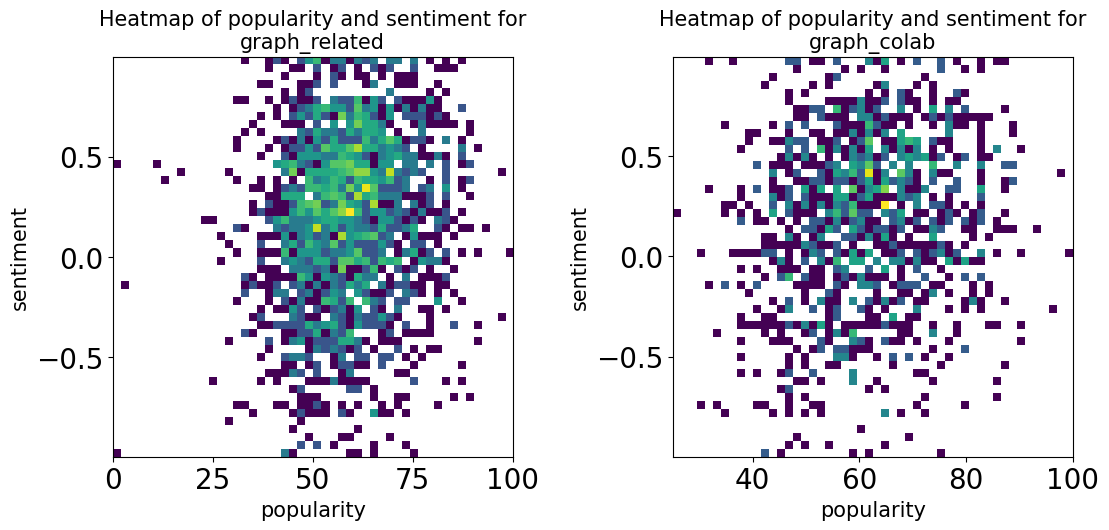

In [201]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5)) #, constrained_layout=False)
fig.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)

heatmap, extent = helper.get_heat_map(x_axis_related, y_axis_related, bin_size=50)
axs[0].imshow(heatmap.T, extent=extent, origin='lower',
               norm=LogNorm(), aspect='auto')
axs[0].set_title("\n".join(wrap("Heatmap of popularity and sentiment for graph_related", 40)), fontsize=15)
axs[0].set_xlabel("popularity", fontsize=15)
axs[0].set_ylabel("sentiment", fontsize=15)

heatmap, extent = helper.get_heat_map(x_axis_colab, y_axis_colab, bin_size=50)
axs[1].imshow(heatmap.T, extent=extent, origin='lower',
               norm=LogNorm(), aspect='auto')
axs[1].set_title("\n".join(wrap("Heatmap of popularity and sentiment for graph_colab", 40)), fontsize=15)
axs[1].set_xlabel("popularity", fontsize=15)
axs[1].set_ylabel("sentiment", fontsize=15)
plt.show()

We see the heatmap comparing the popularity and the sentiment of the nodes.
Since the collaborating graph is a sub graph of the graph related we have the same plot but in the collaborating heatmap we have less data points. The densest point in the graph is in the popularity range 45 – 75 and the sentiment range 0.2 – 0.6 and we only have a few outliers. The popularity and the sentiment do not correlate, resulting from the shape of a circle.

### Degree Distribution

Degree distribution of the whole graph

**Distribution for the graphs**

In [78]:
hist_in_related, bin_edges_in_related = helper.get_degree_distribution(graph_related)
hist_in_colab, bin_edges_in_colab = helper.get_degree_distribution(graph_colab)

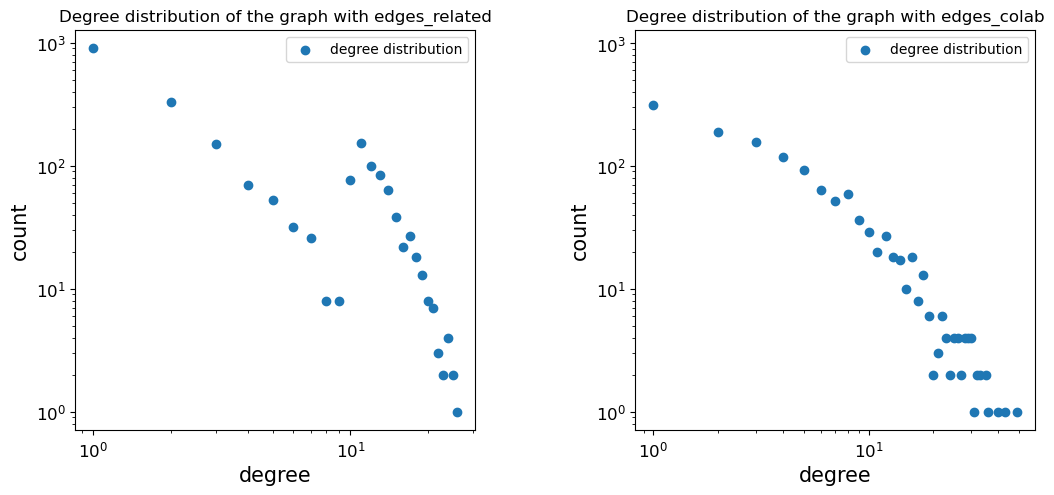

In [79]:
# draw degree distributions
fig, axs = plt.subplots(1, 2, figsize=(12, 5)) #, constrained_layout=False)
fig.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)

# %matplotlib inline
axs[0].scatter(bin_edges_in_related[:-1],
                hist_in_related, label="degree distribution")
axs[0].set_title("Degree distribution of the graph with edges_related")
axs[0].set_xlabel("degree", fontsize=15)
axs[0].set_ylabel("count", fontsize=15)
axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].legend()

axs[1].scatter(bin_edges_in_colab[:-1],
                hist_in_colab, label="degree distribution")
axs[1].set_title("Degree distribution of the graph with edges_colab")
axs[1].set_xlabel("degree", fontsize=15)
axs[1].set_ylabel("count", fontsize=15)
axs[1].set_xscale('log')
axs[1].set_yscale('log')
axs[1].legend()

plt.show()

The plots above show the degree distribution of both networks.
The degree distributions suggest that the graph is a power law distribution. However, the related graph has an interesting break inside the distribution. It would need more datapoints to investigate this.

**Distribution for mood**

We are taking one mood and plotting the nodes in a degree distribution

In [202]:
# getting mood map
happy = "Happy"
angry = "Angry"


binary_nodes_related_happy = helper.calculate_binar_map_mood(graph_related, artists_wMood, happy)
binary_nodes_colab_happy = helper.calculate_binar_map_mood(graph_colab, artists_wMood, happy)
binary_nodes_related_angry = helper.calculate_binar_map_mood(graph_related, artists_wMood, angry)
binary_nodes_colab_angry = helper.calculate_binar_map_mood(graph_colab, artists_wMood, angry)

In [203]:
# getting ids of the nodes activated in the mood map
list_nodes_related_happy = helper.get_node_id_from_binary_map(graph_related, binary_nodes_related_happy)
list_nodes_colab_happy = helper.get_node_id_from_binary_map(graph_colab, binary_nodes_colab_happy)
list_nodes_related_angry = helper.get_node_id_from_binary_map(graph_related, binary_nodes_related_angry)
list_nodes_colab_angry = helper.get_node_id_from_binary_map(graph_colab, binary_nodes_colab_angry)

In [204]:
# getting the degree distribution
hist_in_related_happy, bin_edges_in_related_happy = helper.get_degree_distribution_nodes(graph_related, list_nodes_related_happy)
hist_in_colab_happy, bin_edges_in_colab_happy = helper.get_degree_distribution_nodes(graph_colab, list_nodes_colab_happy)
hist_in_related_angry, bin_edges_in_related_angry = helper.get_degree_distribution_nodes(graph_related, list_nodes_related_angry)
hist_in_colab_angry, bin_edges_in_colab_angry = helper.get_degree_distribution_nodes(graph_colab, list_nodes_colab_angry)

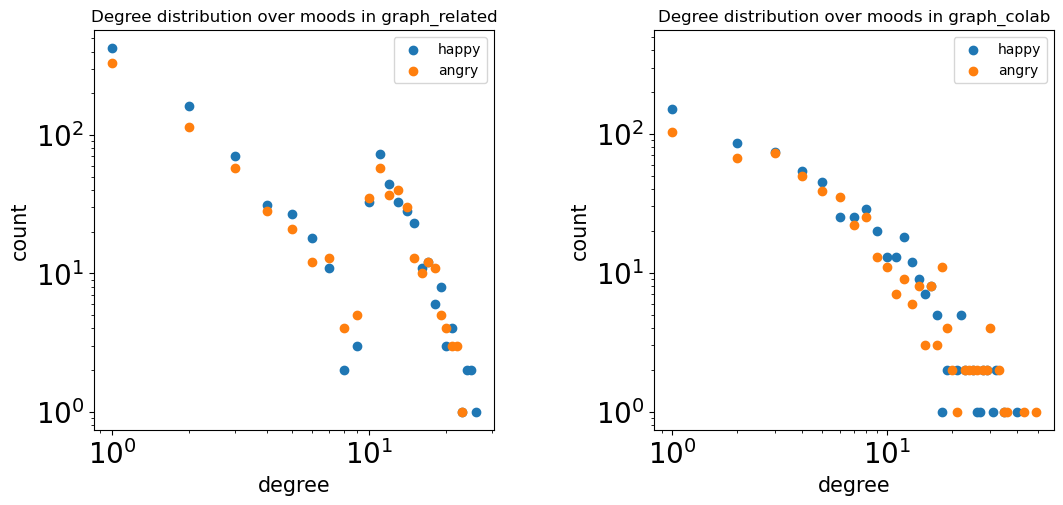

In [205]:
# draw degree distributions
fig, axs = plt.subplots(1, 2, figsize=(12, 5)) #, constrained_layout=False)
fig.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)

# %matplotlib inline
axs[0].scatter(bin_edges_in_related_happy[:-1],
                hist_in_related_happy, label="happy")
axs[0].set_xlabel("degree", fontsize=15)
axs[0].set_ylabel("count", fontsize=15)
axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].legend()

axs[1].scatter(bin_edges_in_colab_happy[:-1],
                hist_in_colab_happy, label="happy")
axs[1].set_xlabel("degree", fontsize=15)
axs[1].set_ylabel("count", fontsize=15)
axs[1].set_xscale('log')
axs[1].set_yscale('log')
axs[1].legend()

axs[0].scatter(bin_edges_in_related_angry[:-1],
                hist_in_related_angry, label="angry")
axs[0].set_title("Degree distribution over moods in graph_related")
axs[0].set_xlabel("degree", fontsize=15)
axs[0].set_ylabel("count", fontsize=15)
axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].legend()

axs[1].scatter(bin_edges_in_colab_angry[:-1],
                hist_in_colab_angry, label="angry")
axs[1].set_title("Degree distribution over moods in graph_colab")
axs[1].set_xlabel("degree", fontsize=15)
axs[1].set_ylabel("count", fontsize=15)
axs[1].set_xscale('log')
axs[1].set_yscale('log')
axs[1].legend()

plt.show()

The above plot shows the degree distribution of the nodes with the main moods:"happy" and "angry". Since we only have a few samples of the moods: "calm" and "sad" we are leaving these out. The several moods follow the same pattern usual for their network and are pretty mixed. This comes to the conclusion that the both moods follow the same distribution. 

**Distribution for communities**

We are taking the largest community and plotting the degree distribution of this one.

In [84]:
# get community nodes
com_dict_related = helper.get_communities(graph_related, seed)
com_related = helper.conv_community_dict(com_dict_related)

com_dict_colab = helper.get_communities(graph_colab, seed)
com_colab = helper.conv_community_dict(com_dict_colab)

In [85]:
hist_in_related, bin_edges_in_related = helper.get_degree_distribution_nodes(graph_related, com_related[list(com_related.keys())[0]])
hist_in_colab, bin_edges_in_colab = helper.get_degree_distribution_nodes(graph_colab, com_colab[list(com_colab.keys())[0]])

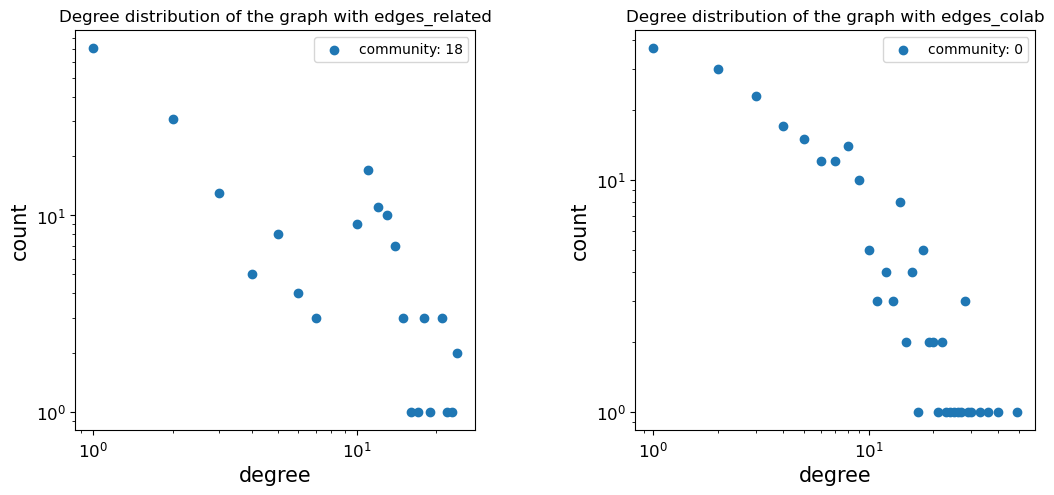

In [86]:
# draw degree distributions
fig, axs = plt.subplots(1, 2, figsize=(12, 5)) #, constrained_layout=False)
fig.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)

# %matplotlib inline
axs[0].scatter(bin_edges_in_related[:-1],
                hist_in_related, label="community: "+str(list(com_related.keys())[0]))
axs[0].set_title("Degree distribution of the graph with edges_related")
axs[0].set_xlabel("degree", fontsize=15)
axs[0].set_ylabel("count", fontsize=15)
axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].legend()

axs[1].scatter(bin_edges_in_colab[:-1],
                hist_in_colab, label="community: "+str(list(com_colab.keys())[0]))
axs[1].set_title("Degree distribution of the graph with edges_colab")
axs[1].set_xlabel("degree", fontsize=15)
axs[1].set_ylabel("count", fontsize=15)
axs[1].set_xscale('log')
axs[1].set_yscale('log')
axs[1].legend()

plt.show()

The two plots show the degree distribution of the nodes inside the largest communities in each network. Like the previous distributions they follow the distribution of the network and therefore there are no interesting new findings.

**Distribution for the sentiment**

We are taking nodes with a positive sentiment [0.5,1] and plotting the degree distribution

In [206]:
sentiment_neg = (-1.0,-0.05)
sentiment_neu = (-0.0499999,0.0499999)
sentiment_pos = (0.05,1.0)

sentiment_nodes_pos = helper.get_all_nodes_with_sentiment(artists_wMood, sentiment_pos)
sentiment_nodes_neu = helper.get_all_nodes_with_sentiment(artists_wMood, sentiment_neu)
sentiment_nodes_neg = helper.get_all_nodes_with_sentiment(artists_wMood, sentiment_neg)

In [207]:
hist_in_related_pos, bin_edges_in_related_pos = helper.get_degree_distribution_nodes(graph_related, sentiment_nodes_pos)
hist_in_related_neu, bin_edges_in_related_neu = helper.get_degree_distribution_nodes(graph_related, sentiment_nodes_neu)
hist_in_related_neg, bin_edges_in_related_neg = helper.get_degree_distribution_nodes(graph_related, sentiment_nodes_neg)

hist_in_colab_pos, bin_edges_in_colab_pos = helper.get_degree_distribution_nodes(graph_colab, sentiment_nodes_pos)
hist_in_colab_neu, bin_edges_in_colab_neu = helper.get_degree_distribution_nodes(graph_colab, sentiment_nodes_neu)
hist_in_colab_neg, bin_edges_in_colab_neg = helper.get_degree_distribution_nodes(graph_colab, sentiment_nodes_neg)

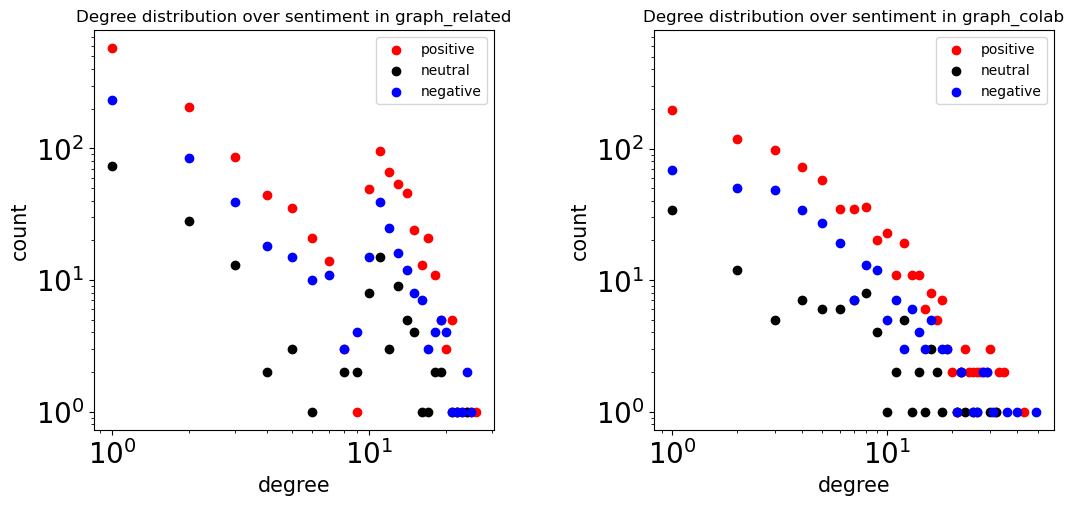

In [208]:
# draw degree distributions
fig, axs = plt.subplots(1, 2, figsize=(12, 5)) #, constrained_layout=False)
fig.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)

# %matplotlib inline
axs[0].scatter(bin_edges_in_related_pos[:-1],
                hist_in_related_pos, label="positive", color="r")
axs[0].scatter(bin_edges_in_related_neu[:-1],
                hist_in_related_neu, label="neutral", color="k")
axs[0].scatter(bin_edges_in_related_neg[:-1],
                hist_in_related_neg, label="negative", color="b")
axs[0].set_title("Degree distribution over sentiment in graph_related")
axs[0].set_xlabel("degree", fontsize=15)
axs[0].set_ylabel("count", fontsize=15)
axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].legend()

axs[1].scatter(bin_edges_in_colab_pos[:-1],
                hist_in_colab_pos, label="positive", color="r")
axs[1].scatter(bin_edges_in_colab_neu[:-1],
                hist_in_colab_neu, label="neutral", color="k")
axs[1].scatter(bin_edges_in_colab_neg[:-1],
                hist_in_colab_neg, label="negative", color="b")
axs[1].set_title("Degree distribution over sentiment in graph_colab")
axs[1].set_xlabel("degree", fontsize=15)
axs[1].set_ylabel("count", fontsize=15)
axs[1].set_xscale('log')
axs[1].set_yscale('log')
axs[1].legend()

plt.show()

The plot above shows the degree distributions over the sentiment ranges positiv, neutral and negativ. The different sentiment ranges follow the previous degree distributions and nothing different can be seen. Note that the different sentiment ranges are a bit biased since they have different node amounts. There are apparently the most positiv, then negativ and the fewest neutral amount of nodes. This is the reason because of the choosen sentiment ranges of the classes(positiv, negativ, neutral).

# Friendship paradox

In this section we are investigating the friendship paradox for both graphs. In order to see if it is true for a specific percentage of nodes.

**Related graph**

In [90]:
paradox_true = 0
node_list = random.sample(list(graph_related.nodes()), len(graph_related.nodes())) #1000 random nodes(without replacement, so its 1000 different nodes)

for j in range(0, len(node_list)):
    i = node_list[j] #person i
    i_friends = graph_related.degree(i)
    
    neighbors = list(graph_related.neighbors(i)) #neighbors of person i
    neighbor_degree = np.array(graph_related.degree(neighbors))[:,1] #degree for the neigbors
    avg_friends = sum(list(map(int, neighbor_degree))) / len(neighbor_degree) #average degree for the neighbor
    
    if avg_friends > i_friends:
        paradox_true += 1
        
print("Friendship paradox is True :" + str((paradox_true/len(graph_related.nodes()))*100))

Friendship paradox is True :79.32910244786945


**Collaboration graph**

In [91]:
paradox_true = 0
node_list = random.sample(list(graph_colab_calc.nodes()), len(graph_colab_calc.nodes())) #1000 random nodes(without replacement, so its 1000 different nodes)

for j in range(0, len(node_list)):
    i = node_list[j] #person i
    i_friends = graph_colab_calc.degree(i)
    
    neighbors = list(graph_colab_calc.neighbors(i)) #neighbors of person i
    neighbor_degree = np.array(graph_colab_calc.degree(neighbors))[:,1] #degree for the neigbors
    avg_friends = sum(list(map(int, neighbor_degree))) / len(neighbor_degree) #average degree for the neighbor
    
    if avg_friends > i_friends:
        paradox_true += 1
        
print("Friendship paradox is True :" + str((paradox_true/len(graph_colab_calc.nodes()))*100))

Friendship paradox is True :79.4753086419753


We tested each node and compared the count of the neighbors of this node with the average count of the neighbors of the neighbors. The Friendship paradox ist for both networks for about 80% of the nodes true. Leading to the solution that 80% of the nodes have less connections to other artists than the neighbors in average.

# Communities

**Size of the communities**

In [93]:
# get largest community sorted first
def value_getter(item):
    return item[0]

In [94]:
# node size communities
com_related = helper.get_communities(graph_related, seed)
com_related = helper.conv_community_dict(com_related)
#print([len(com_related[k]) for k in list(com_related.keys())])

com_colab = helper.get_communities(graph_colab_calc, seed)
com_colab = helper.conv_community_dict(com_colab)

# sorted
partition_sorted = sorted(
    com_related.items(), key=value_getter, reverse=False)
sorted_dict = {}
for key, value in partition_sorted:
    sorted_dict[key] = value

print("Graph_related: Communities amount of nodes: \n" + str([(len(sorted_dict[i])) for i in com_related.keys()]))
print("Graph_colab: Communities amount of nodes: \n" + str([len(com_colab[i]) for i in com_colab.keys()]))

Graph_related: Communities amount of nodes: 
[205, 161, 145, 128, 125, 123, 117, 116, 114, 108, 102, 90, 68, 63, 61, 60, 58, 54, 50, 50, 49, 42, 39, 38, 29, 11]
Graph_colab: Communities amount of nodes: 
[240, 226, 159, 125, 90, 80, 66, 50, 48, 43, 39, 14, 14, 8, 5, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


The above result shows the amount of nodes inside each community of both networks. The result is presented as a list and was sorted in descending order. We have a lot of communities inside the collaborating network, which only have 2 or 3 nodes. These comes from the type of sampling we did.

**The average degree of the communities**

In [95]:
# node size communities
com_related = helper.get_communities(graph_related, seed)
com_related = helper.conv_community_dict(com_related)
avg_degree_related = []
count = 0
for k in com_related.keys():
    avg_degree_related.append([k,0])
    for i in com_related[k]:
        avg_degree_related[count][1] += graph_related.degree(i)
    avg_degree_related[count][1] = avg_degree_related[count][1]/len(com_related[k])
    count += 1

com_colab = helper.get_communities(graph_colab_calc, seed)
com_colab = helper.conv_community_dict(com_colab)
avg_degree_colab = []
count = 0
# not all communities are pictured here. The last ones are all 2.0 
for k in list(com_colab.keys())[:80]:
    avg_degree_colab.append([k,0])
    for i in com_colab[k]:
        avg_degree_colab[count][1] += graph_colab.degree(i)
    avg_degree_colab[count][1] = avg_degree_colab[count][1]/len(com_colab[k])
    count += 1

# sorted related
partition_sorted = sorted(
    avg_degree_related, key=value_getter, reverse=False)
sorted_dict = {}
for key, value in partition_sorted:
    sorted_dict[key] = value
    
# sorted colab
partition_sorted = sorted(
    avg_degree_colab, key=value_getter, reverse=False)
sorted_dict_colab = {}
for key, value in partition_sorted:
    sorted_dict_colab[key] = value
    
print("Graph_related: Communities average degree of nodes [community_id, average_degree]: \n" + str(sorted_dict))
print("Graph_colab: Communities average degree of nodes [community_id, average_degree]: \n" + str(sorted_dict_colab))


Graph_related: Communities average degree of nodes [community_id, average_degree]: 
{0: 6.96875, 1: 5.700854700854701, 2: 3.5310344827586206, 3: 6.9937888198757765, 4: 7.517241379310345, 5: 8.602941176470589, 6: 4.688888888888889, 7: 4.571428571428571, 8: 4.248, 9: 3.888888888888889, 10: 3.82, 11: 3.4444444444444446, 12: 3.9444444444444446, 13: 6.524590163934426, 14: 4.22, 15: 5.368421052631579, 16: 8.551724137931034, 17: 1.9090909090909092, 18: 5.95609756097561, 19: 3.268292682926829, 20: 3.1206896551724137, 21: 4.040816326530612, 22: 4.526315789473684, 23: 4.533333333333333, 24: 5.313725490196078, 25: 5.051282051282051}
Graph_colab: Communities average degree of nodes [community_id, average_degree]: 
{0: 7.937106918238993, 1: 6.991150442477876, 2: 1.0, 3: 9.696, 4: 4.2272727272727275, 5: 4.2555555555555555, 6: 4.608333333333333, 7: 6.104166666666667, 8: 2.0, 9: 3.7435897435897436, 10: 1.3333333333333333, 11: 4.3375, 12: 3.66, 13: 1.0, 14: 1.0, 15: 1.0, 16: 3.9285714285714284, 17: 1.3

The above results show for each community the average degree of the nodes inside of this community. 

### Related graph

In [96]:
# get partition
partition_related = helper.get_communities(graph_related, seed)

In [97]:
# export to file
helper.export_communities_to_file(graph_related, seed, "communities_related")

In [98]:
# color
color_map_communities_related = helper.calculate_color_map_communities(graph_related, seed)

In [99]:
# node size
node_size_map_degree = helper.calculate_node_size_map_degree(graph_related)

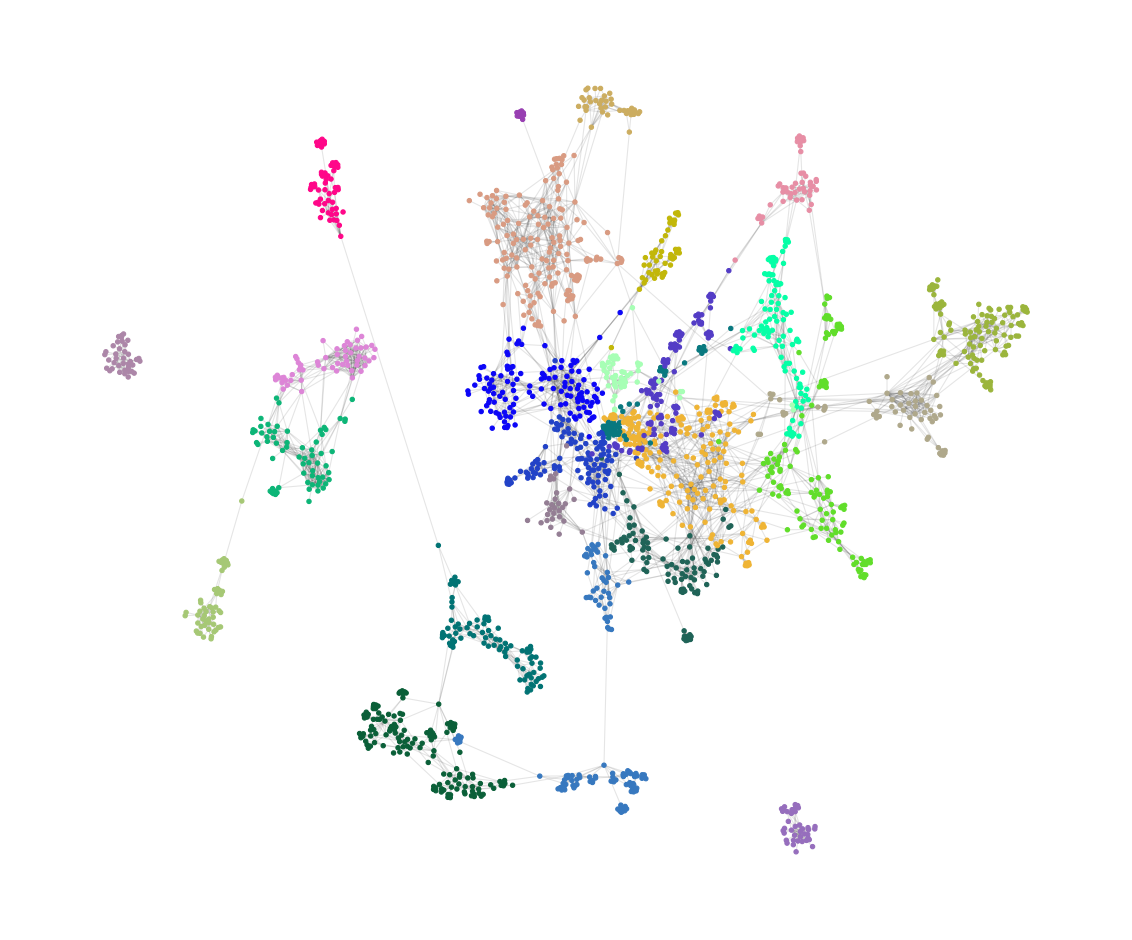

In [100]:
helper.draw_network(graph_related, positions,
             alpha_nodes=1.0, color_map_nodes=color_map_communities_related, node_size=15.0, 
             alpha_edges=0.1, color_map_edges='black',
            )

The above graph shows the related network sectioned into communities. Each color represents a different community.

#### Mood

In [101]:
all_moods = helper.get_all_moods(artists_wMood)

mood = all_moods[1]
print(mood)

Angry


In [102]:
# calculate color map depending on mood
color_map_communities_related = helper.calculate_color_map_communities(graph_related, seed)
color_mood_map_related, alpha_mood_map_related = helper.calculate_color_map_mood(graph_related, artists_wMood, node_color_map=color_map_communities_related, mood=mood)

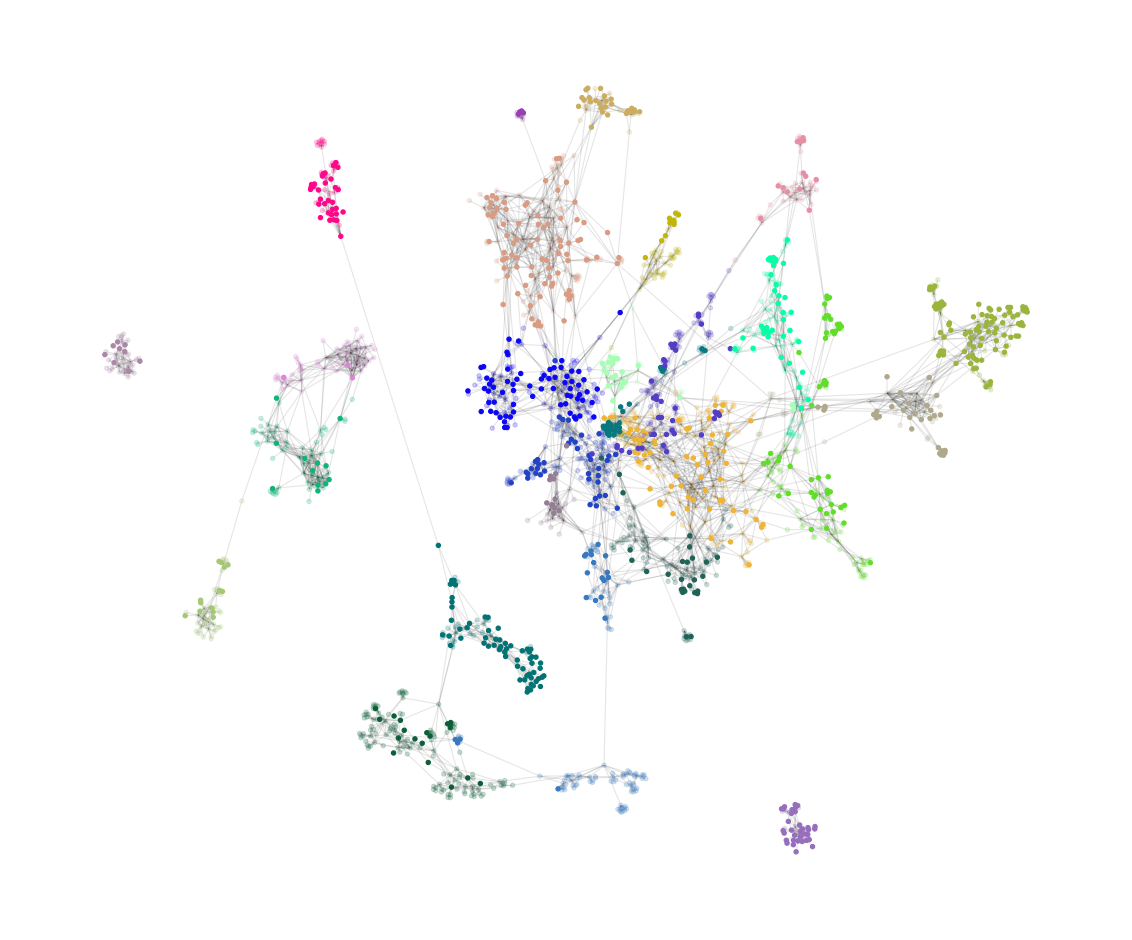

In [103]:
# draw graph with communities and genre
helper.draw_network(graph_related, positions,
             alpha_nodes=alpha_mood_map_related, color_map_nodes=color_map_communities_related, node_size=15.0, 
             alpha_edges=0.1, color_map_edges='black',
            )

In this plot we marked out the mood happy in each community. Notice that the nodes, which do not belong to the class "Happy" are shown transparent. Each color represents the same community as in the graph above. We can see a lot of nodes with the mood happy. Some communities are not as dense as before but they are still there containing some nodes of the mood happy.

In [104]:
helper.get_amount_mood_communities(artists_wMood, graph_related, seed)

Calculate node_count for mood: Sad

[(0, {'included': 7, 'total': 128, 'percentage': 5.46875}), (1, {'included': 29, 'total': 117, 'percentage': 24.786324786324787}), (2, {'included': 21, 'total': 145, 'percentage': 14.482758620689657}), (3, {'included': 19, 'total': 161, 'percentage': 11.801242236024844}), (4, {'included': 3, 'total': 29, 'percentage': 10.344827586206897}), (5, {'included': 1, 'total': 68, 'percentage': 1.4705882352941175}), (6, {'included': 0, 'total': 90, 'percentage': 0.0}), (7, {'included': 0, 'total': 42, 'percentage': 0.0}), (8, {'included': 46, 'total': 125, 'percentage': 36.8}), (9, {'included': 21, 'total': 108, 'percentage': 19.444444444444446}), (10, {'included': 3, 'total': 50, 'percentage': 6.0}), (11, {'included': 6, 'total': 63, 'percentage': 9.523809523809524}), (12, {'included': 3, 'total': 54, 'percentage': 5.555555555555555}), (13, {'included': 1, 'total': 61, 'percentage': 1.639344262295082}), (14, {'included': 0, 'total': 50, 'percentage': 0.0}), 

With this output we printed out the stats of the last plot. You can see for each mood the amount of nodes which belong to this mood and are contained in the different communities. 

"included" means that this amount of nodes with the specific mood are in this specific community. "total" represents the total amount of nodes inside this community. And "percentage" is the percentage of nodes which are of the specific mood and belong to this specific community.

#### Genre

In [105]:
most_genre,all_genre = helper.get_most_genre(artists_wMood)

all_genre_cat = {}
for g in range(5):
    all_genre_cat[most_genre[g][0]] = []
    for i in all_genre:
        if most_genre[g][0] in i:
            all_genre_cat[most_genre[g][0]].append(i)

for i in list(all_genre_cat.keys()):
    for j in range(len(all_genre_cat[i])):
        all_genre_cat[i][j] = all_genre_cat[i][j].replace("hip-hop", "hip hop") # replace again
        all_genre_cat[i][j] = all_genre_cat[i][j].replace("tr-ap", "trap") # replace again

genre = all_genre_cat[most_genre[0][0]]
print(genre)

['neon pop punk', 'transpop', 'pop house', 'pop punk', 'modern indie pop', 'desi pop', 'korean pop', 'noise pop', 'brill building pop', 'art pop', 'danish pop', 'bitpop', 'uk alternative pop', 'power pop', 'britpop', 'britpop revival', 'sophisti-pop', 'argentine telepop', 'dominican pop', 'experimental pop', 'pop venezolano', 'canadian pop punk', 'pop dance', 'nyc pop', 'pop edm', 'latin viral pop', 'pop argentino', 'europop', 'bubblegum pop', 'pop soul', 'jangle pop', 'hyperpop', 'pop reggaeton', 'pop peruano', 'canadian electropop', 'pop quebecois', 'deep pop edm', 'gauze pop', 'k-pop girl group', 'metropopolis', 'sunshine pop', 'colombian pop', 'new wave pop', 'chamber pop', 'pop emo', 'pop rock', 'stomp pop', 'pop rap', 'teen pop', 'k-pop', 'pop', 'scandipop', 'channel pop', 'barbadian pop', 'panamanian pop', 'hip pop', 'spanish pop rock', 'australian pop', 'norwegian pop', 'popping', 'dance pop', 'canadian pop', 'synthpop', 'alternative pop rock', 'la pop', 'dark pop', 'irish pop'

In [106]:
# calculate color map depending on genre
color_map_communities_related = helper.calculate_color_map_communities(graph_related, seed)
color_map_genre_related, color_map_genre_alpha_related = helper.calculate_color_map_genre(graph_related, artists_data, genre, color_map_communities_related, color_genre_node='black', alpha=0.2)

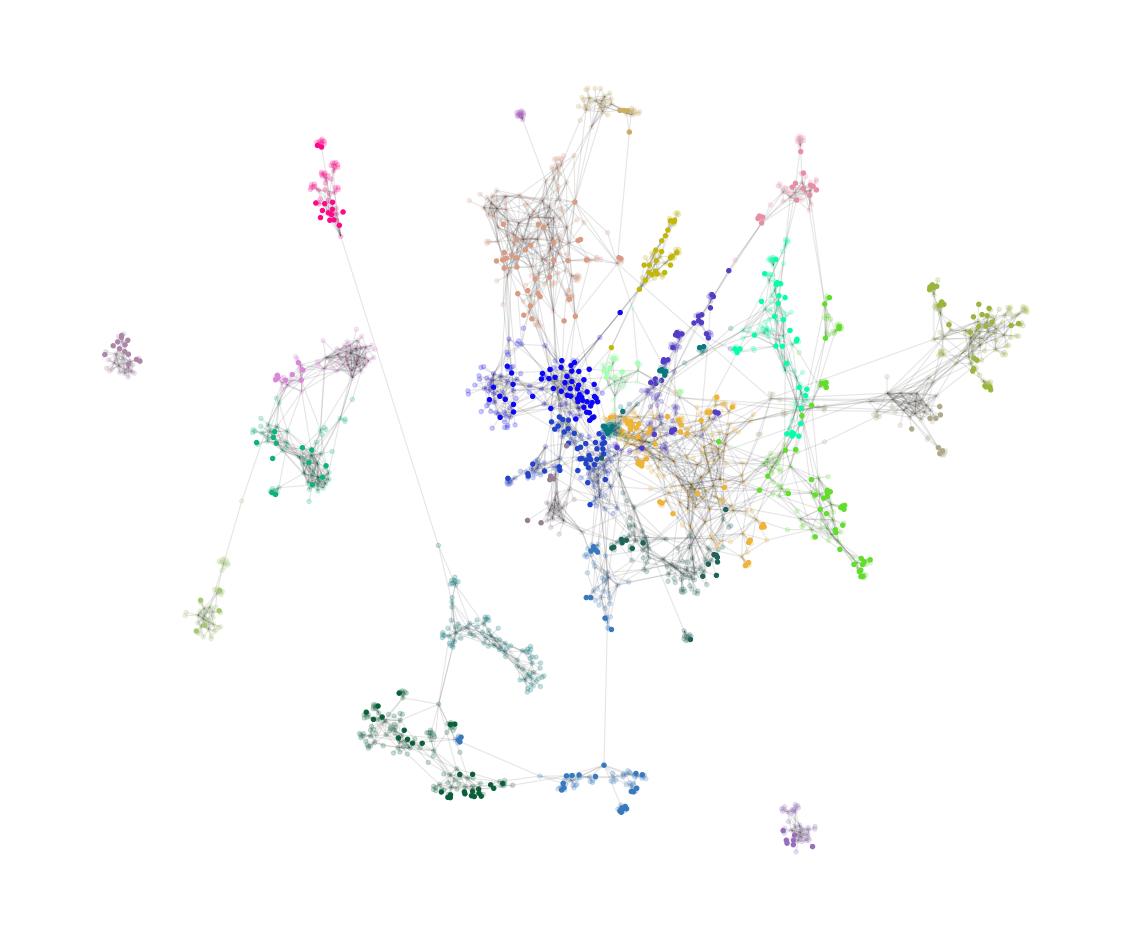

In [107]:
# draw graph with communities and genre
helper.draw_network(graph_related, positions,
             alpha_nodes=color_map_genre_alpha_related, color_map_nodes=color_map_communities_related, node_size=15.0, 
             alpha_edges=0.1, color_map_edges='black',
            )

In this plot we marked out the genre pop in each community. Note that this is really only the nodes which contain the genre "pop". There are also a lot of subgrenre of pop for example "american pop" and much more. Each color represents one community. You can see that the communities there are a lot of communities which contain a lot of nodes with the genre pop. You can asume that communities are connecting depending on the genre.

In [108]:
#genre amount nodes in communities
helper.get_amount_genre_communities(artists_wMood, graph_related, seed)

Calculate node_count for genre: pop

[(0, {'included': 68, 'total': 128, 'percentage': 53.125}), (1, {'included': 80, 'total': 117, 'percentage': 68.37606837606837}), (2, {'included': 61, 'total': 145, 'percentage': 42.06896551724138}), (3, {'included': 42, 'total': 161, 'percentage': 26.08695652173913}), (4, {'included': 29, 'total': 29, 'percentage': 100.0}), (5, {'included': 32, 'total': 68, 'percentage': 47.05882352941176}), (6, {'included': 1, 'total': 90, 'percentage': 1.1111111111111112}), (7, {'included': 7, 'total': 42, 'percentage': 16.666666666666664}), (8, {'included': 110, 'total': 125, 'percentage': 88.0}), (9, {'included': 66, 'total': 108, 'percentage': 61.111111111111114}), (10, {'included': 41, 'total': 50, 'percentage': 82.0}), (11, {'included': 14, 'total': 63, 'percentage': 22.22222222222222}), (12, {'included': 54, 'total': 54, 'percentage': 100.0}), (13, {'included': 55, 'total': 61, 'percentage': 90.1639344262295}), (14, {'included': 29, 'total': 50, 'percentage

In the above output we printed out again the more specific information of the communities in the context of the genre. Note that we merged the different genres of for example pop into one category. We extracted the 5 genres, which where divided the most into subgenres and got the specific community information about each of these 5 genre. 

"included" means that this amount of nodes with the specific mood are in this specific community. "total" represents the total amount of nodes inside this community. And "percentage" is the percentage of nodes which are of the specific mood and belong to this specific community.

### Collaboration graph

In [109]:
partition_colab = helper.get_communities(graph_colab, seed)

In [110]:
# export to file
helper.export_communities_to_file(graph_colab, seed, "communities_colab")

In [111]:
# color
color_map_communities_colab = helper.calculate_color_map_communities(graph_colab, seed)

# alpha degree
alpha_degree = helper.calculate_alpha_degree(graph_colab)

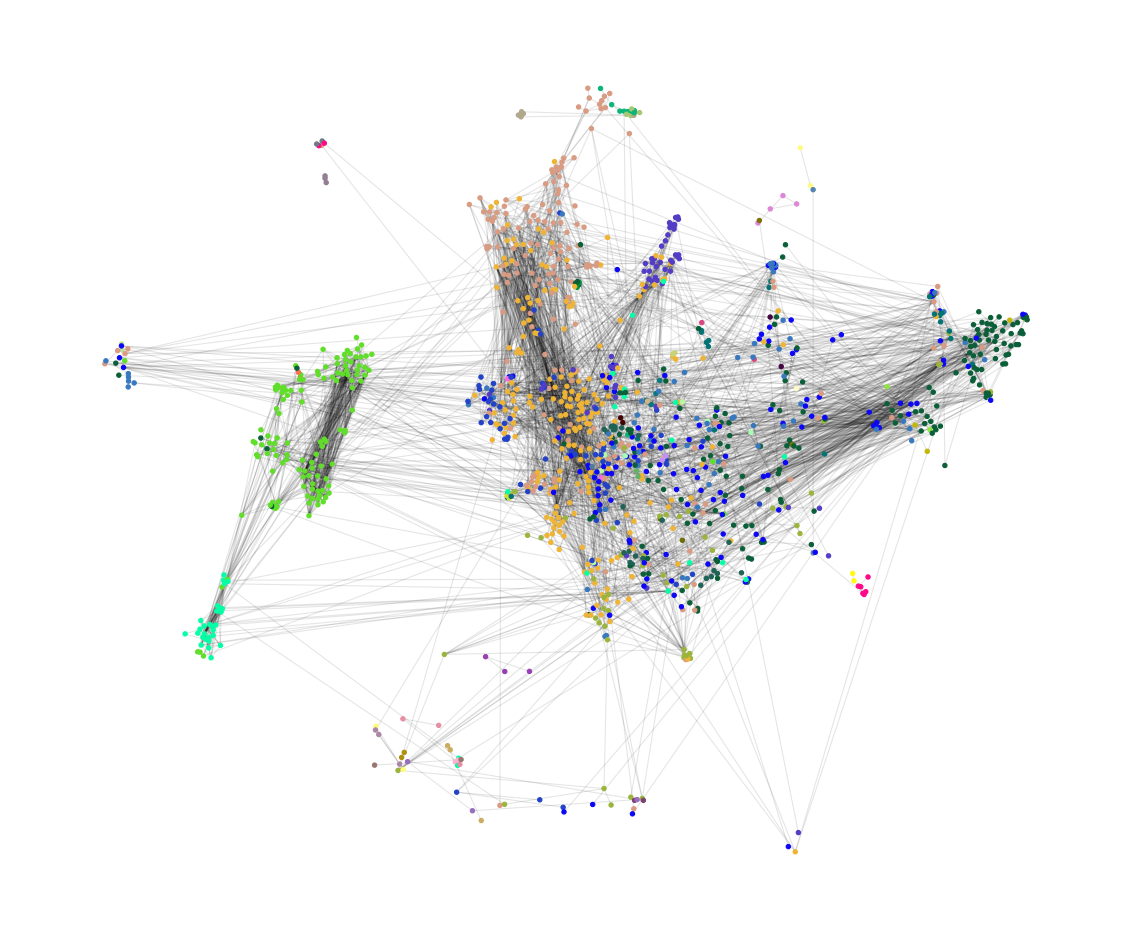

In [112]:
helper.draw_network(graph_colab, positions,
             alpha_nodes=alpha_degree, color_map_nodes=color_map_communities_colab, node_size=15.0,             
             alpha_edges=0.1, color_map_edges='black', labels=False
            )

The above graph shows the collaboration network sectioned into communities. Each color represents a different community.

#### Mood

Happy


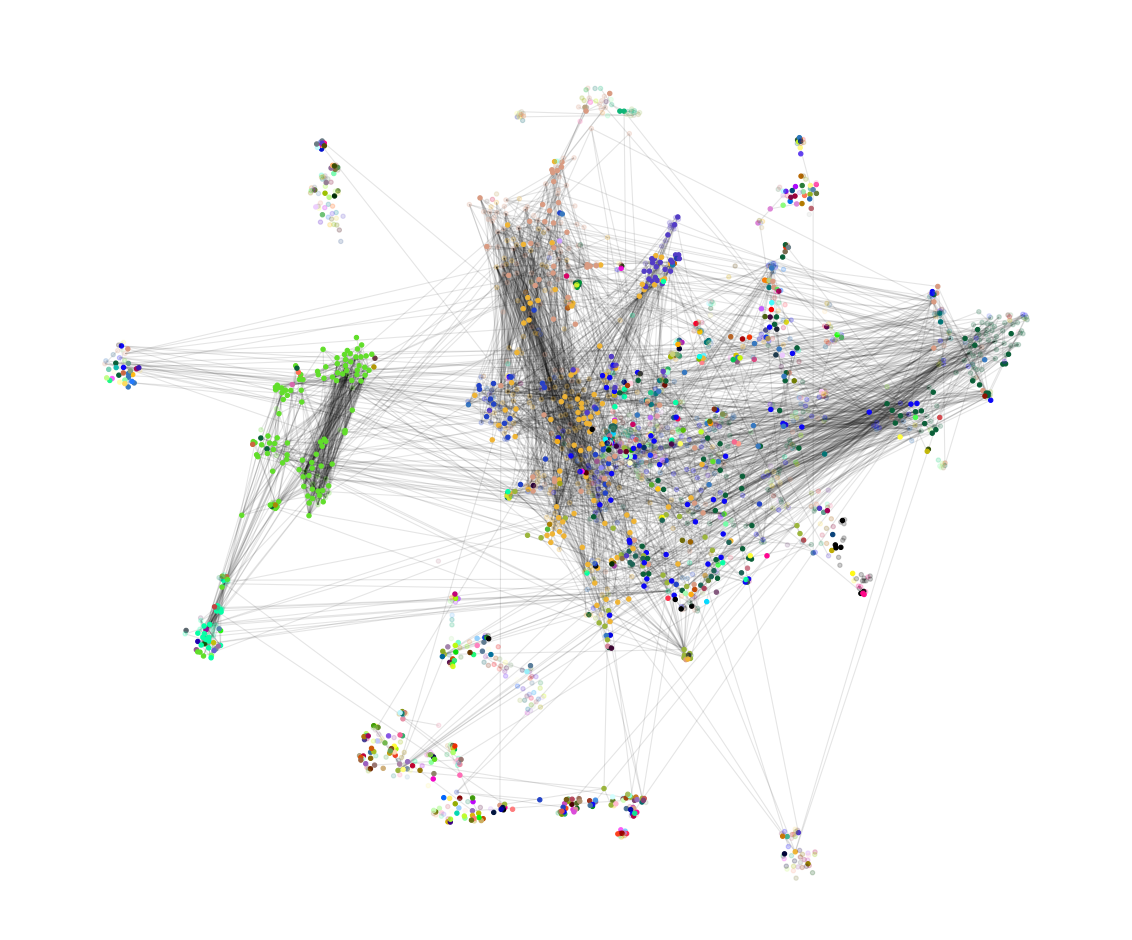

In [113]:
all_moods = helper.get_all_moods(artists_wMood)

mood = "Happy"
print(mood)

# calculate color map depending on mood
color_map_communities_colab = helper.calculate_color_map_communities(graph_colab, seed)
color_mood_map_colab, alpha_mood_map_colab = helper.calculate_color_map_mood(graph_colab, artists_wMood, node_color_map=color_map_communities_colab, mood=mood)

# draw graph with communities and genre
helper.draw_network(graph_colab, positions,
             alpha_nodes=alpha_mood_map_colab, color_map_nodes=color_map_communities_colab, node_size=15.0, 
             alpha_edges=0.1, color_map_edges='black',
            )

In this plot we marked out the mood happy in each community of the collaboration network. Notice that the nodes, which do not belong to the class "Happy" are shown transparent. Each color represents the same community as in the graph above. It seems pretty mixed but this comes from the fact, that we have a lot of communities in this graph which consist out of one node.

Note that we have a community on the left side which is completely visible and out of one community.

In [114]:
#amount of nodes with mood in communities
helper.get_amount_mood_communities(artists_wMood, graph_colab_calc, seed)

Calculate node_count for mood: Sad

[(0, {'included': 17, 'total': 159, 'percentage': 10.69182389937107}), (1, {'included': 21, 'total': 226, 'percentage': 9.29203539823009}), (2, {'included': 1, 'total': 2, 'percentage': 50.0}), (3, {'included': 1, 'total': 125, 'percentage': 0.8}), (4, {'included': 4, 'total': 66, 'percentage': 6.0606060606060606}), (5, {'included': 8, 'total': 90, 'percentage': 8.88888888888889}), (6, {'included': 34, 'total': 240, 'percentage': 14.166666666666666}), (7, {'included': 3, 'total': 48, 'percentage': 6.25}), (8, {'included': 1, 'total': 4, 'percentage': 25.0}), (9, {'included': 8, 'total': 39, 'percentage': 20.51282051282051}), (10, {'included': 0, 'total': 3, 'percentage': 0.0}), (11, {'included': 3, 'total': 80, 'percentage': 3.75}), (12, {'included': 13, 'total': 50, 'percentage': 26.0}), (13, {'included': 1, 'total': 2, 'percentage': 50.0}), (14, {'included': 1, 'total': 2, 'percentage': 50.0}), (15, {'included': 2, 'total': 2, 'percentage': 100.0})

[(0, {'included': 5, 'total': 159, 'percentage': 3.1446540880503147}), (1, {'included': 1, 'total': 226, 'percentage': 0.4424778761061947}), (2, {'included': 0, 'total': 2, 'percentage': 0.0}), (3, {'included': 0, 'total': 125, 'percentage': 0.0}), (4, {'included': 1, 'total': 66, 'percentage': 1.5151515151515151}), (5, {'included': 1, 'total': 90, 'percentage': 1.1111111111111112}), (6, {'included': 0, 'total': 240, 'percentage': 0.0}), (7, {'included': 0, 'total': 48, 'percentage': 0.0}), (8, {'included': 0, 'total': 4, 'percentage': 0.0}), (9, {'included': 1, 'total': 39, 'percentage': 2.564102564102564}), (10, {'included': 0, 'total': 3, 'percentage': 0.0}), (11, {'included': 1, 'total': 80, 'percentage': 1.25}), (12, {'included': 1, 'total': 50, 'percentage': 2.0}), (13, {'included': 0, 'total': 2, 'percentage': 0.0}), (14, {'included': 1, 'total': 2, 'percentage': 50.0}), (15, {'included': 0, 'total': 2, 'percentage': 0.0}), (16, {'included': 0, 'total': 14, 'percentage': 0.0}), 

The results above represent again the amount of nodes in each community which hit the condition of having the mood happy.

"included" means that this amount of nodes with the specific mood are in this specific community. "total" represents the total amount of nodes inside this community. And "percentage" is the percentage of nodes which are of the specific mood and belong to this specific community.

#### Genre

['neon pop punk', 'transpop', 'pop house', 'pop punk', 'modern indie pop', 'desi pop', 'korean pop', 'noise pop', 'brill building pop', 'art pop', 'danish pop', 'bitpop', 'uk alternative pop', 'power pop', 'britpop', 'britpop revival', 'sophisti-pop', 'argentine telepop', 'dominican pop', 'experimental pop', 'pop venezolano', 'canadian pop punk', 'pop dance', 'nyc pop', 'pop edm', 'latin viral pop', 'pop argentino', 'europop', 'bubblegum pop', 'pop soul', 'jangle pop', 'hyperpop', 'pop reggaeton', 'pop peruano', 'canadian electropop', 'pop quebecois', 'deep pop edm', 'gauze pop', 'k-pop girl group', 'metropopolis', 'sunshine pop', 'colombian pop', 'new wave pop', 'chamber pop', 'pop emo', 'pop rock', 'stomp pop', 'pop rap', 'teen pop', 'k-pop', 'pop', 'scandipop', 'channel pop', 'barbadian pop', 'panamanian pop', 'hip pop', 'spanish pop rock', 'australian pop', 'norwegian pop', 'popping', 'dance pop', 'canadian pop', 'synthpop', 'alternative pop rock', 'la pop', 'dark pop', 'irish pop'

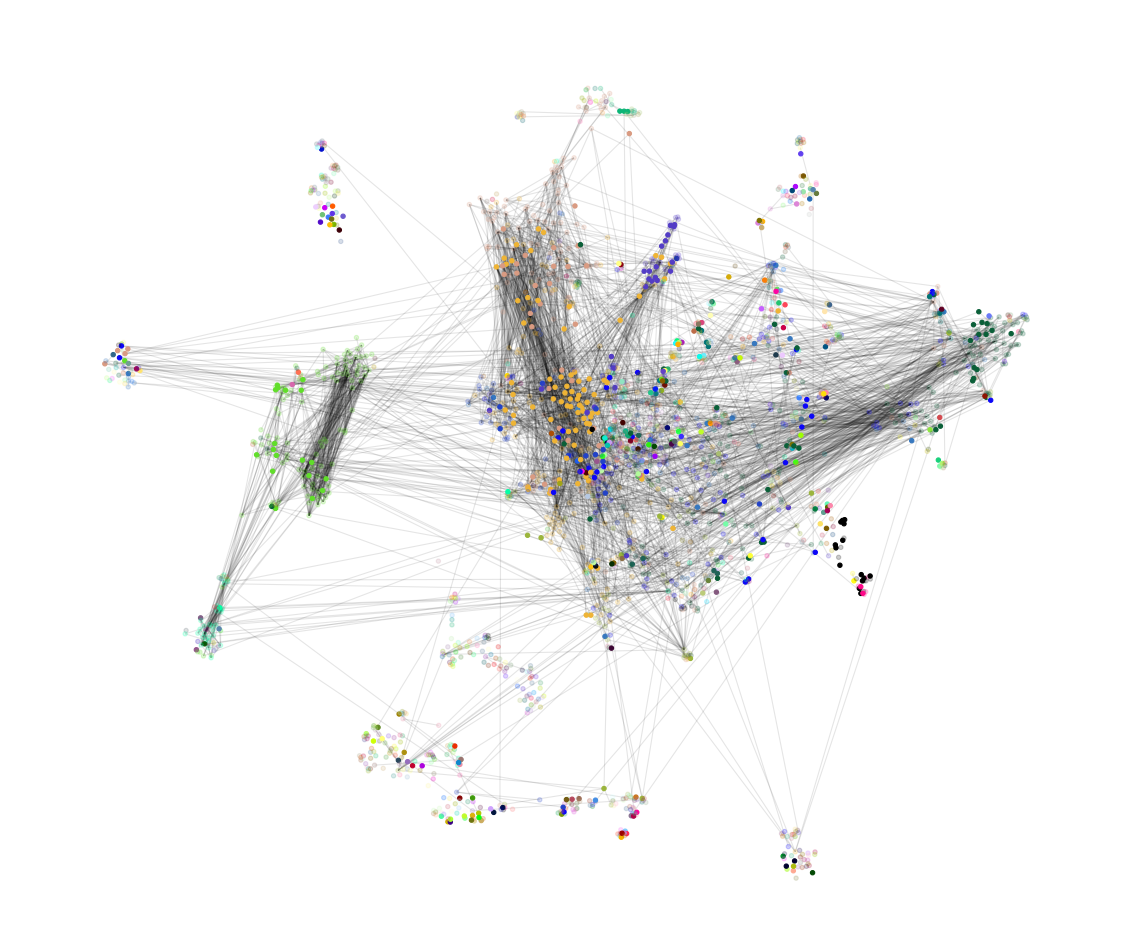

In [115]:
most_genre,all_genre = helper.get_most_genre(artists_wMood)

all_genre_cat = {}
for g in range(5):
    all_genre_cat[most_genre[g][0]] = []
    for i in all_genre:
        if most_genre[g][0] in i:
            all_genre_cat[most_genre[g][0]].append(i)

for i in list(all_genre_cat.keys()):
    for j in range(len(all_genre_cat[i])):
        all_genre_cat[i][j] = all_genre_cat[i][j].replace("hip-hop", "hip hop") # replace again
        all_genre_cat[i][j] = all_genre_cat[i][j].replace("tr-ap", "trap") # replace again

genre = all_genre_cat[most_genre[0][0]]
print(genre)

# calculate color map depending on genre
color_map_communities_colab = helper.calculate_color_map_communities(graph_colab, seed)
color_map_genre_colab, color_map_genre_alpha_colab = helper.calculate_color_map_genre(graph_colab, artists_data, genre, color_map_communities_colab, color_genre_node='black', alpha=0.2)

# draw graph with communities and genre
helper.draw_network(graph_colab, positions,
             alpha_nodes=color_map_genre_alpha_colab, color_map_nodes=color_map_communities_colab, node_size=15.0, 
             alpha_edges=0.1, color_map_edges='black',
            )

The above graph shows the genre pop inclusive the subgenre of pop. Also check out the list over the graph for an detailed averview over all subgenre. 

The graph is sectioned in communities and each color represents a different community. On first sight the graph and colorization looks random and there is no pattern. If we take a closer look into the largest connected component we see that there are a lot nodes which are with the genre pop. This leads to the assumption that pop is related to the 100 most streamed artists.

In [116]:
#genre amount nodes in communities
helper.get_amount_genre_communities(artists_wMood, graph_colab_calc, seed)

Calculate node_count for genre: pop

[(0, {'included': 70, 'total': 159, 'percentage': 44.0251572327044}), (1, {'included': 147, 'total': 226, 'percentage': 65.04424778761062}), (2, {'included': 2, 'total': 2, 'percentage': 100.0}), (3, {'included': 51, 'total': 125, 'percentage': 40.8}), (4, {'included': 49, 'total': 66, 'percentage': 74.24242424242425}), (5, {'included': 76, 'total': 90, 'percentage': 84.44444444444444}), (6, {'included': 212, 'total': 240, 'percentage': 88.33333333333333}), (7, {'included': 46, 'total': 48, 'percentage': 95.83333333333334}), (8, {'included': 1, 'total': 4, 'percentage': 25.0}), (9, {'included': 33, 'total': 39, 'percentage': 84.61538461538461}), (10, {'included': 3, 'total': 3, 'percentage': 100.0}), (11, {'included': 57, 'total': 80, 'percentage': 71.25}), (12, {'included': 24, 'total': 50, 'percentage': 48.0}), (13, {'included': 0, 'total': 2, 'percentage': 0.0}), (14, {'included': 1, 'total': 2, 'percentage': 50.0}), (15, {'included': 2, 'total':

[(0, {'included': 70, 'total': 159, 'percentage': 44.0251572327044}), (1, {'included': 136, 'total': 226, 'percentage': 60.17699115044248}), (2, {'included': 0, 'total': 2, 'percentage': 0.0}), (3, {'included': 64, 'total': 125, 'percentage': 51.2}), (4, {'included': 15, 'total': 66, 'percentage': 22.727272727272727}), (5, {'included': 8, 'total': 90, 'percentage': 8.88888888888889}), (6, {'included': 3, 'total': 240, 'percentage': 1.25}), (7, {'included': 3, 'total': 48, 'percentage': 6.25}), (8, {'included': 0, 'total': 4, 'percentage': 0.0}), (9, {'included': 1, 'total': 39, 'percentage': 2.564102564102564}), (10, {'included': 0, 'total': 3, 'percentage': 0.0}), (11, {'included': 50, 'total': 80, 'percentage': 62.5}), (12, {'included': 27, 'total': 50, 'percentage': 54.0}), (13, {'included': 1, 'total': 2, 'percentage': 50.0}), (14, {'included': 0, 'total': 2, 'percentage': 0.0}), (15, {'included': 0, 'total': 2, 'percentage': 0.0}), (16, {'included': 0, 'total': 14, 'percentage': 0

In the above output we printed out again the more specific information of the communities in the context of the genre. Note that we merged the different genres of for example pop into one category. We extracted the 5 genres, which where divided the most into subgenres and got the specific community information about each of these 5 genre. 

"included" means that this amount of nodes with the specific mood are in this specific community. "total" represents the total amount of nodes inside this community. And "percentage" is the percentage of nodes which are of the specific mood and belong to this specific community.

# Text Analysis

In [117]:
#preprocessing
tokens_dict = {}
for key in tqdm(lyrics_dict):
    lyric = lyrics_dict[key].replace("\n", " ")
    lemmatized_word = []
    emojis = re.compile("[" u"\U0001F600-\U0001F64F" u"\U0001F300-\U0001F5FF" u"\U0001F680-\U0001F6FF" 
                        u"\U0001F1E0-\U0001F1FF" u"\U0001F1F2-\U0001F1F4" u"\U0001F1E6-\U0001F1FF" 
                        u"\U0001F600-\U0001F64F" u"\U00002702-\U000027B0" u"\U000024C2-\U0001F251"
                        u"\U0001f926-\U0001f937" u"\U0001F1F2" u"\U0001F1F4" u"\U0001F620" u"\u200d" 
                        u"\u2640-\u2642" "]+", flags = re.UNICODE)
    remove_emojis = emojis.sub(r'', lyric) #remove emojis
    lower = remove_emojis.lower().split() #lowercase
    filtered_words = [word for word in lower if not word in stopwords.words('english')]  #remove stop words
    remove_punct = word_tokenize(" ".join(filtered_words).translate(str.maketrans("", "", string.punctuation)))#remove punctuation
    lemmatized = " ".join([lemmatizer.lemmatize(w) for w in remove_punct]) #lemmatize
    final_tokens = word_tokenize(lemmatized) #tokenize
    tokens_dict[int(key)] = final_tokens

  0%|          | 0/17649 [00:00<?, ?it/s]

In [118]:
#index of all songs
index_list = list(tokens_dict.keys())

In [119]:
#all track names that were found and possible to translate
track_lyrics = tracks.iloc[index_list]

In [120]:
#number of tracks that were found
len(track_lyrics)

17649

In [121]:
#all tracks where either lyrics could not be found or translated to english
len(tracks[~tracks['track_name'].isin(track_lyrics.track_name)])

3642

3642 could not be found or translated.

In [122]:
#artists where no lyrics could be found or translated to english
artists_df[~artists_df['id'].isin(track_lyrics.artist_id)]

id                     name  number_of_followers  \
376   51sg5jUqKu2tkbmPlwPrNH                BTS World              1262972   
378   3E0zmIZJN85yOovfGHoH8k  BTS Island: In the SEOM               168623   
473   07d5etnpjriczFBB8pxmRe       BJ The Chicago Kid               409428   
474   1FvjvACFvko2Z91IvDljrx             Mick Jenkins               555326   
475   0oBsnAC3fzYkTHF3bkfNx6                Phony Ppl               250766   
...                      ...                      ...                  ...   
547   0G8zjE6SsFTlbglCkU8pm3               Starsailor               196140   
548   18Zv2g2vUcEGqJf6WnjfXN          Brandon Flowers               433890   
549   21UJ7PRWb3Etgsu99f8yo8            Stereophonics              1361940   
1200  1UUvXNGYI5Rib9vh2516FT                     WRLD                 1246   
1779  0o42tCraU6AHXirBdleTO4                    Vassy                    5   

                                                 genres  popularity  \
376                             ['korean instrumental']          35   
378                                                  []          32   
473   ['alternative r&b', 'chicago rap', 'hip hop', ...          59   
474   ['chicago rap', 'conscious hip hop', 'drill', ...          59   
475                   ['alternative r&b', 'indie soul']          49   
...                                                 ...         ...   
547   ['britpop', 'lancashire indie', 'piano rock', ...          46   
548                                     ['vegas indie']          50   
549   ['britpop', 'modern rock', 'neo mellow', 'pop ...          62   
1200                                                 []          32   
1779                                                 []           0   

                                             top_tracks   mood  \
376   [{'album_id': '3LgNJmZ4QPkSvdt9JB8Tb8', 'album...    Sad   
378   [{'album_id': '6GJeTp7bCvX9yCw28vL5cx', 'album...    Sad   
473   [{'album_id': '15iSR05cslUeYgf2kuWDhu', 'album...   Calm   
474   [{'album_id': '4SnWrk06dIt4ynFRLpNX6e', 'album...  Angry   
475   [{'album_id': '6IGDCUkBJ3LEUoAcoTD46u', 'album...  Happy   
...                                                 ...    ...   
547   [{'album_id': '08wcM2mrpdOqmd28XL4IdV', 'album...  Happy   
548   [{'album_id': '7zKxFkMyehmw9u3MhLpMPK', 'album...  Angry   
549   [{'album_id': '1DwcGY8AK9RS0IgmozyvyP', 'album...  Angry   
1200                                                 []    NaN   
1779                                                 []    NaN   

      avg_lyrics_sentiment  avg_trackname_sentiment  
376                    NaN                 0.430129  
378                    NaN                 0.000000  
473                    NaN                -0.051060  
474                    NaN                 0.032710  
475                    NaN                 0.007950  
...                    ...                      ...  
547                    NaN                 0.016240  
548                    NaN                -0.063470  
549                    NaN                -0.042340  
1200                   NaN                      NaN  
1779                   NaN                      NaN  

[81 rows x 9 columns]

For 81 artists, no lyrics are found/translated. For 2 of the artists, it is because no tracks was listed, when the data was downloaded for these artists. 

In [123]:
#artists where lyrics was found/translated
artists_df = artists_df[artists_df['id'].isin(track_lyrics.artist_id)]

In [124]:
#number of artists after preprocessing
len(artists_df)

2125

### Basic stat for tracks and artists

In [125]:
# Settings for the next plots
plt.rc('xtick', labelsize=18)    # fontsize of the tick labels
plt.rc('ytick', labelsize=18)    # fontsize of the tick labels

#### Mood

In [209]:
#mood for tracks and artists
track_mood = track_lyrics.groupby('mood').count()
artist_mood = artists_df.groupby('mood').count()

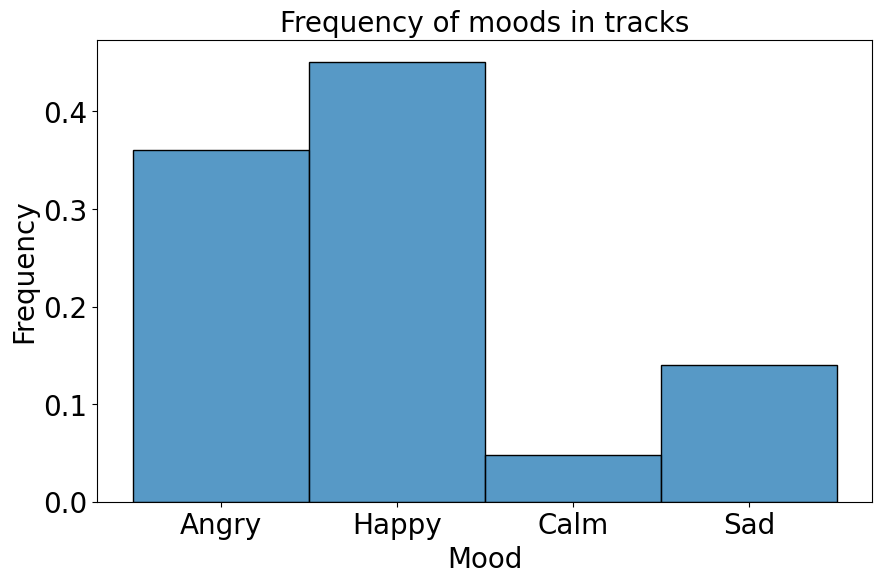

In [211]:
plt.figure(figsize=(10,6))
sns.histplot(data=track_lyrics, x="mood", stat = "probability")
plt.ylabel("Frequency", fontsize=20)
plt.xlabel("Mood", fontsize=20)
plt.title("Frequency of moods in tracks", fontsize=20)
plt.show()

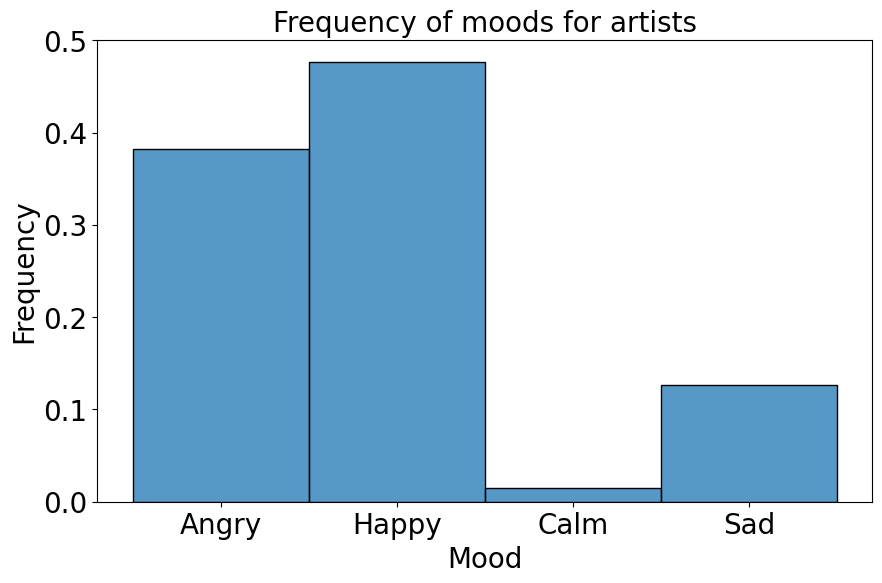

In [212]:
plt.figure(figsize=(10,6))
sns.histplot(data=artists_df, x="mood", stat = "probability")
plt.ylabel("Frequency", fontsize=20)
plt.xlabel("Mood", fontsize=20)
plt.title("Frequency of moods for artists", fontsize=20)
plt.show()

#### Sentiment

In [263]:
#sentiment for tracks and artists
track_p10 = np.percentile(track_lyrics["track_lyrics_sentiment_compound"], 10)
track_p90 = np.percentile(track_lyrics["track_lyrics_sentiment_compound"], 90)
track_sentiment_mean = track_lyrics["track_lyrics_sentiment_compound"].mean()

artist_p10 = np.percentile(artists_df["avg_lyrics_sentiment"], 10)
artist_p90 = np.percentile(artists_df["avg_lyrics_sentiment"], 90)
artist_sentiment_mean = artists_df["avg_lyrics_sentiment"].mean()

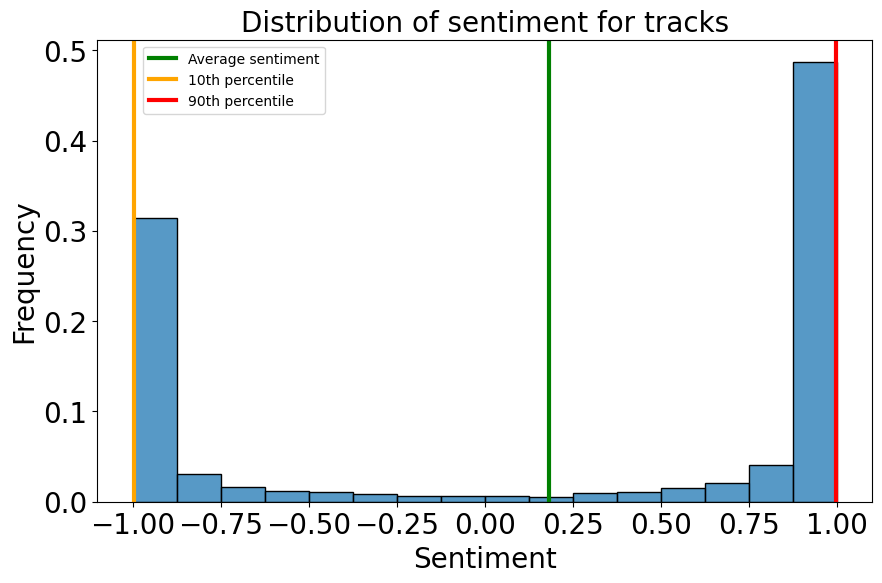

In [264]:
plt.figure(figsize=(10,6))
sns.histplot(data=track_lyrics, x="track_lyrics_sentiment_compound", stat = 'probability')
plt.axvline(track_sentiment_mean, 0,1, color = 'green', label = 'Average sentiment', linewidth = 3)
plt.axvline(track_p10, 0,1, color = 'orange', label = '10th percentile', linewidth = 3)
plt.axvline(track_p90, 0,1, color = 'red', label = '90th percentile', linewidth = 3)
plt.xlabel("Sentiment", fontsize=20)
plt.ylabel('Frequency', fontsize=20)
plt.title("Distribution of sentiment for tracks", fontsize=20)

plt.legend(loc='upper left', bbox_to_anchor=(0.05, 1))

plt.show()

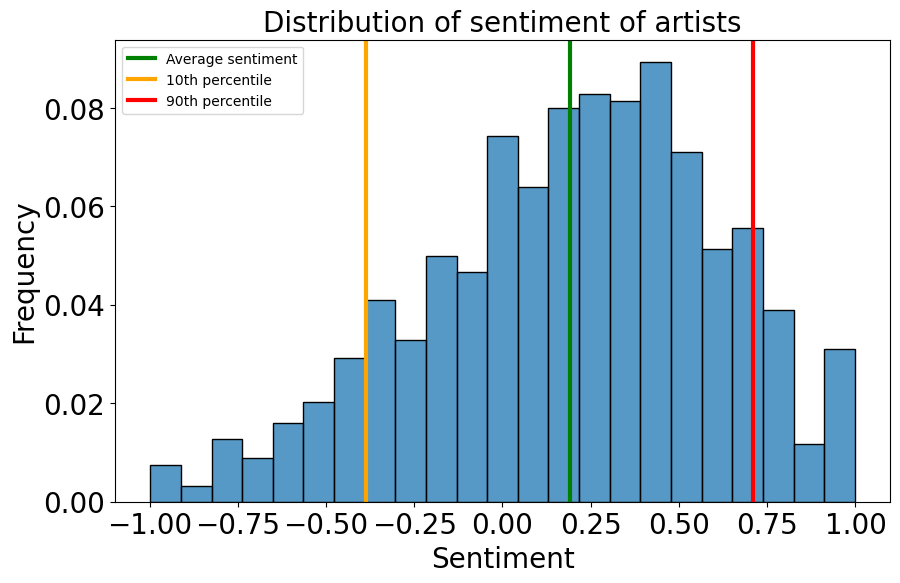

In [265]:
plt.figure(figsize=(10,6))
sns.histplot(data=artists_df, x="avg_lyrics_sentiment", stat = "probability")
plt.axvline(artist_sentiment_mean, 0,1, color = "green", label = "Average sentiment", linewidth = 3)
plt.axvline(artist_p10, 0,1, color = "orange", label = "10th percentile", linewidth = 3)
plt.axvline(artist_p90, 0,1, color = "red", label = "90th percentile", linewidth = 3)
plt.ylabel("Frequency", fontsize=20)
plt.xlabel("Sentiment", fontsize=20)
plt.title("Distribution of sentiment of artists", fontsize=20)
plt.legend()

plt.show()

#### Popularity

In [266]:
track_popularity_p10 = np.percentile(track_lyrics.track_popularity, 10)
track_popularity_p90 = np.percentile(track_lyrics.track_popularity, 90)
track_popularity_mean = track_lyrics.track_popularity.mean()

artist_popularity_p10 = np.percentile(artists_df.popularity, 10)
artist_popularity_p90 = np.percentile(artists_df.popularity, 90)
artist_popularity_mean = artists_df.popularity.mean()

In [267]:
print("mean popularity for tracks:", track_popularity_mean)
print("mean popularity for  artists:", artist_popularity_mean)

mean popularity for tracks: 52.3371295824126
mean popularity for  artists: 58.329882352941176


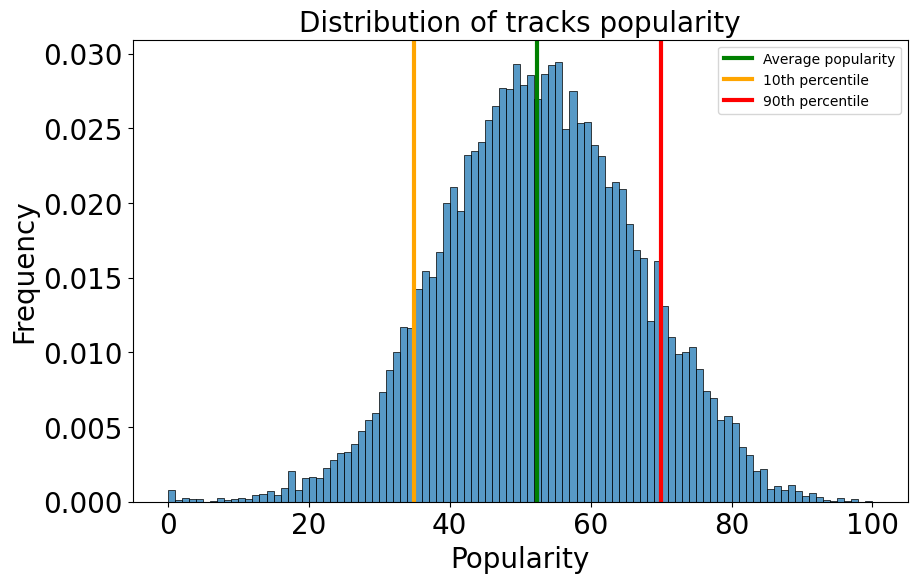

In [268]:
plt.figure(figsize=(10,6))
sns.histplot(data=track_lyrics, x="track_popularity", stat = "probability", bins = 100)
plt.axvline(track_popularity_mean, 0,1, color = "green", label = "Average popularity", linewidth = 3)
plt.axvline(track_popularity_p10, 0,1, color = "orange", label = "10th percentile", linewidth = 3)
plt.axvline(track_popularity_p90, 0,1, color = "red", label = "90th percentile", linewidth = 3)
plt.ylabel("Frequency", fontsize=20)
plt.xlabel("Popularity", fontsize=20)
plt.title("Distribution of tracks popularity", fontsize=20)
plt.legend()

plt.show()

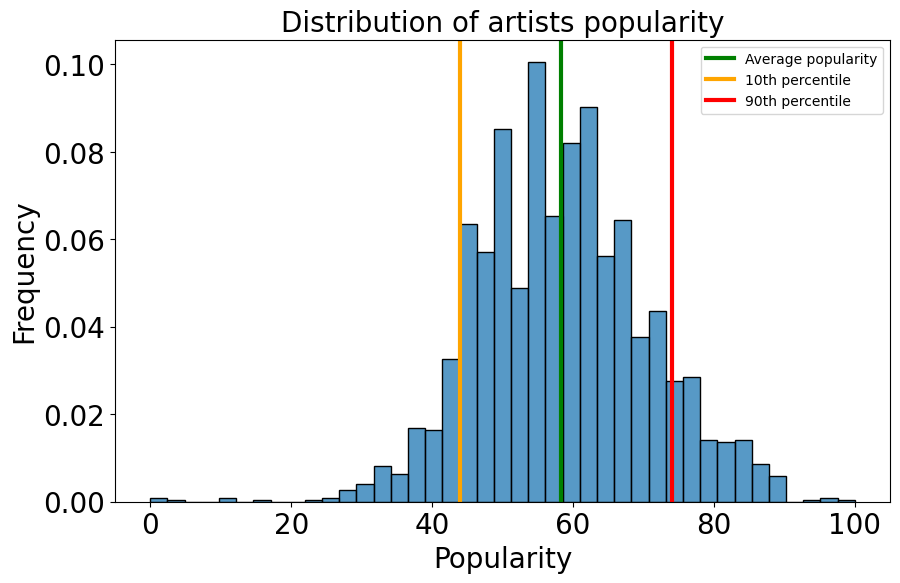

In [269]:
plt.figure(figsize=(10,6))
sns.histplot(data=artists, x="popularity", stat = "probability")
plt.axvline(artist_popularity_mean, 0,1, color = "green", label = "Average popularity", linewidth = 3)
plt.axvline(artist_popularity_p10, 0,1, color = "orange", label = "10th percentile", linewidth = 3)
plt.axvline(artist_popularity_p90, 0,1, color = "red", label = "90th percentile", linewidth = 3)
plt.xlabel("Popularity", fontsize=20)
plt.ylabel("Frequency", fontsize=20)
plt.title("Distribution of artists popularity", fontsize=20)
plt.legend()

plt.show()

### Communities

In [136]:
#when the network part doesn't work
relations = pd.read_csv("communities_related.csv", sep=",", header = None, names = ['community_id', 'id'])

In [137]:
relations['artist_id'] = relations['id'].apply(literal_eval)
artist_df = artists_df.copy()

In [138]:
#add community id to artists
for c in range(0,len(relations)):
    artist_df.loc[artist_df['id'].isin(relations.artist_id.iloc[c]), 'community_id'] = relations.iloc[c].community_id

#### Basic stat

In [139]:
community_mean = artist_df.groupby('community_id').mean().reset_index()

##### Mood

In [140]:
community_mood = artist_df.groupby(['community_id', 'mood']).count().reset_index()
community_mood

community_id   mood  id  name  number_of_followers  genres  popularity  \
0            0.0  Angry  64    64                   64      64          64   
1            0.0  Happy  50    50                   50      50          50   
2            0.0    Sad   7     7                    7       7           7   
3            1.0  Angry  39    39                   39      39          39   
4            1.0   Calm   1     1                    1       1           1   
..           ...    ...  ..   ...                  ...     ...         ...   
74          24.0  Happy  74    74                   74      74          74   
75          24.0    Sad   1     1                    1       1           1   
76          25.0  Angry  26    26                   26      26          26   
77          25.0  Happy   5     5                    5       5           5   
78          25.0    Sad   8     8                    8       8           8   

    top_tracks  avg_lyrics_sentiment  avg_trackname_sentiment  
0           64                    64                       64  
1           50                    50                       50  
2            7                     7                        7  
3           39                    39                       39  
4            1                     1                        1  
..         ...                   ...                      ...  
74          74                    74                       74  
75           1                     1                        1  
76          26                    26                       26  
77           5                     5                        5  
78           8                     8                        8  

[79 rows x 10 columns]

##### Sentiment

In [270]:
#avg sentiment
community_sentiment_avg = community_mean.avg_lyrics_sentiment.mean()
community_sentiment_p10 = np.percentile(community_mean.avg_lyrics_sentiment, 10)
community_sentiment_p90 = np.percentile(community_mean.avg_lyrics_sentiment, 90)

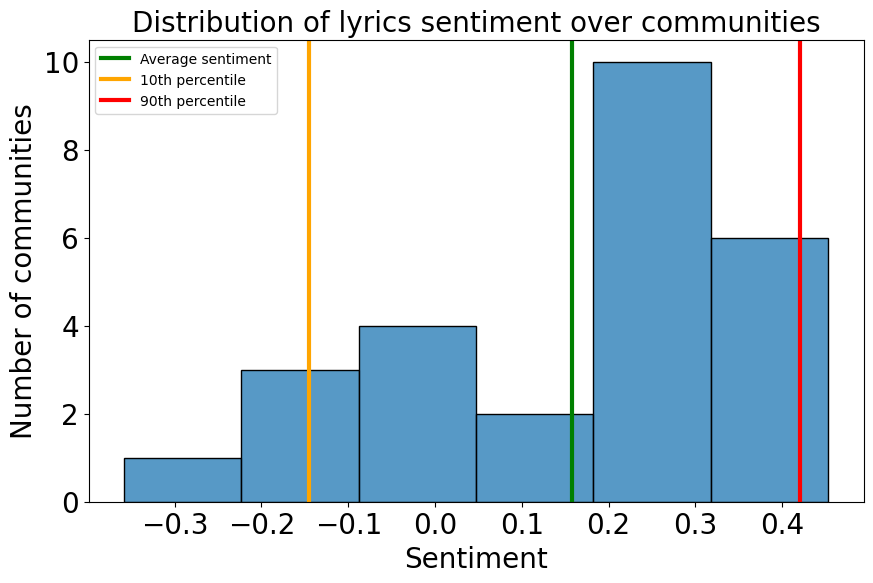

In [272]:
plt.figure(figsize=(10,6))
sns.histplot(data=community_mean, x="avg_lyrics_sentiment")
plt.axvline(community_sentiment_avg, 0,1, color = "green", label = "Average sentiment", linewidth = 3)
plt.axvline(community_sentiment_p10, 0,1, color = "orange", label = "10th percentile", linewidth = 3)
plt.axvline(community_sentiment_p90, 0,1, color = "red", label = "90th percentile", linewidth = 3)
plt.ylabel("Number of communities", fontsize=20)
plt.xlabel("Sentiment", fontsize=20)
plt.title("Distribution of lyrics sentiment over communities", fontsize=20)
plt.legend()
plt.show()

##### Popularity

In [143]:
#avg_popularity
community_popularity_avg = community_mean.popularity.mean()
community_popularity_p10 = np.percentile(community_mean.popularity, 10)
community_popularity_p90 = np.percentile(community_mean.popularity, 90)

In [144]:
print(community_mean.min().popularity)
print(community_mean.max().popularity)

49.38461538461539
68.3970588235294


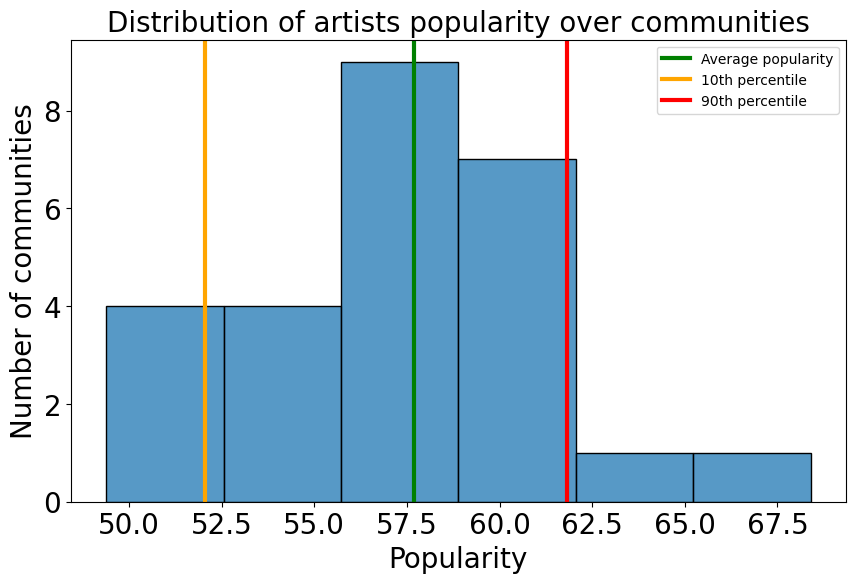

In [223]:
plt.figure(figsize=(10,6))
sns.histplot(data=community_mean, x="popularity")
plt.axvline(community_popularity_avg, 0,1, color = "green", label = "Average popularity", linewidth = 3)
plt.axvline(community_popularity_p10, 0,1, color = "orange", label = "10th percentile", linewidth = 3)
plt.axvline(community_popularity_p90, 0,1, color = "red", label = "90th percentile", linewidth = 3)
plt.ylabel("Number of communities", fontsize=20)
plt.xlabel("Popularity", fontsize=20)
plt.title("Distribution of artists popularity over communities", fontsize=20)
plt.legend()
plt.show()

#### Permutation test

In [224]:
# Settings for the next plots
plt.rc('xtick', labelsize=10)    # fontsize of the tick labels
plt.rc('ytick', labelsize=10)    # fontsize of the tick labels

In [225]:
def label_permutation(df, label_column, iterations, n_communities):
    avg_sentiment = np.zeros((n_communities, iterations))
    avg_popularity = np.zeros((n_communities, iterations))
    for i in range(0,iterations):
        labels = df[label_column]
        permutated_label = np.random.RandomState(i).permutation(labels) #permutate the label
        df["permutated_community"] = permutated_label #new column with permutated labels
        
        avg_sentiment[:,i] = artist_df.groupby('permutated_community').mean().avg_lyrics_sentiment.values
        avg_popularity[:,i] = artist_df.groupby('permutated_community').mean().popularity.values
        
    return avg_sentiment, avg_popularity

In [226]:
sentiment_permutated, popularity_permutated = label_permutation(artist_df, "community_id", 1000, len(relations))

In [227]:
sentiment_permutated_df = pd.DataFrame(sentiment_permutated.T)
popularity_permutated_df = pd.DataFrame(popularity_permutated.T)

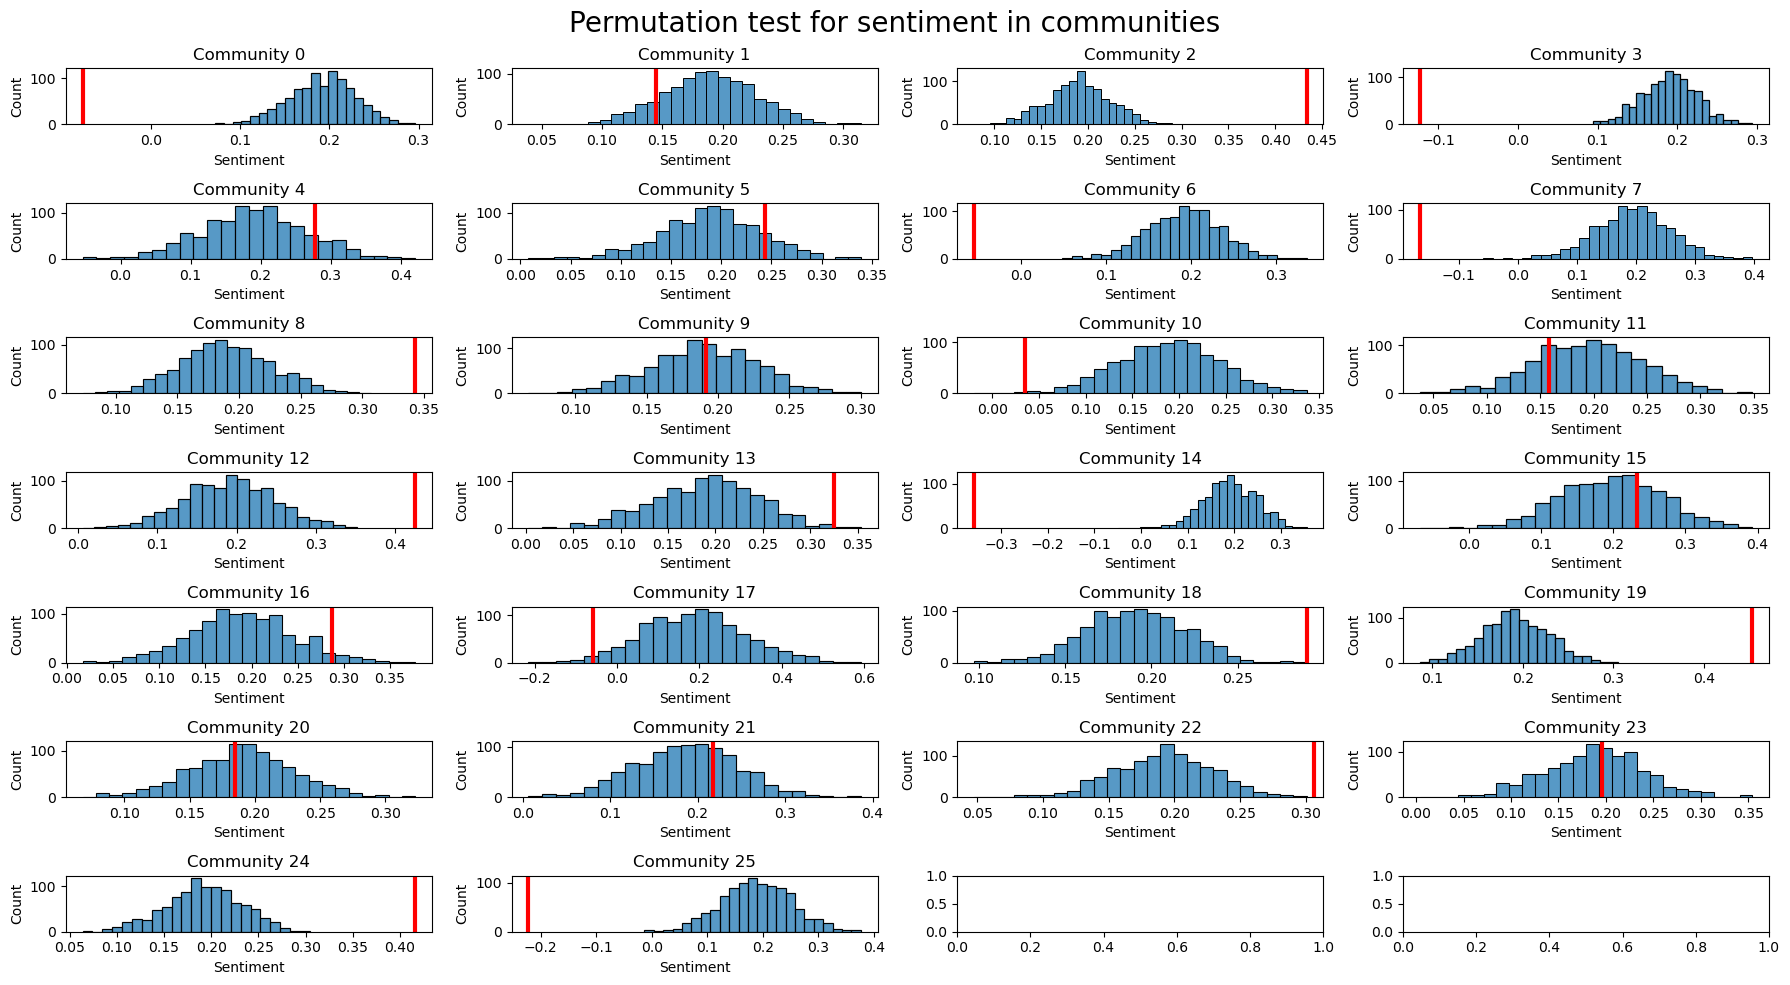

In [232]:
fig, axes = plt.subplots(7, 4, figsize=(18, 10))

i = 0
j = 0
for ind in range(0,np.shape(sentiment_permutated_df)[1]):
    sns.histplot(ax=axes[i,j], data = sentiment_permutated_df, x = ind)
    axes[i,j].axvline(community_mean.iloc[ind].avg_lyrics_sentiment, 0,1, color = "red", linewidth = 3)
    axes[i,j].set_xlabel("Sentiment")
    axes[i,j].set_title("Community " + str(ind))
    
    if j%3 == 0 and j != 0:
        j = 0
        i += 1
    else:
        j += 1
fig.suptitle("Permutation test for sentiment in communities", fontsize=20) 
plt.tight_layout()

In [ ]:
# Settings for the next plots
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels

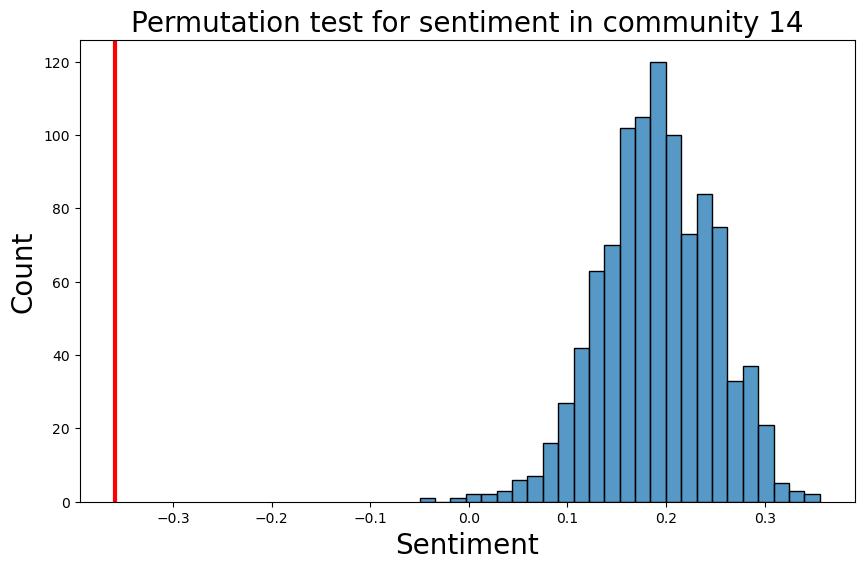

In [234]:
plt.figure(figsize=(10,6))
sns.histplot(data = sentiment_permutated_df, x = 14)
plt.axvline(community_mean.iloc[14].avg_lyrics_sentiment, 0,1, color = "red", linewidth = 3)
plt.xlabel("Sentiment", fontsize=20)
plt.ylabel("Count", fontsize=20)
plt.title("Permutation test for sentiment in community 14", fontsize=20)
plt.show()

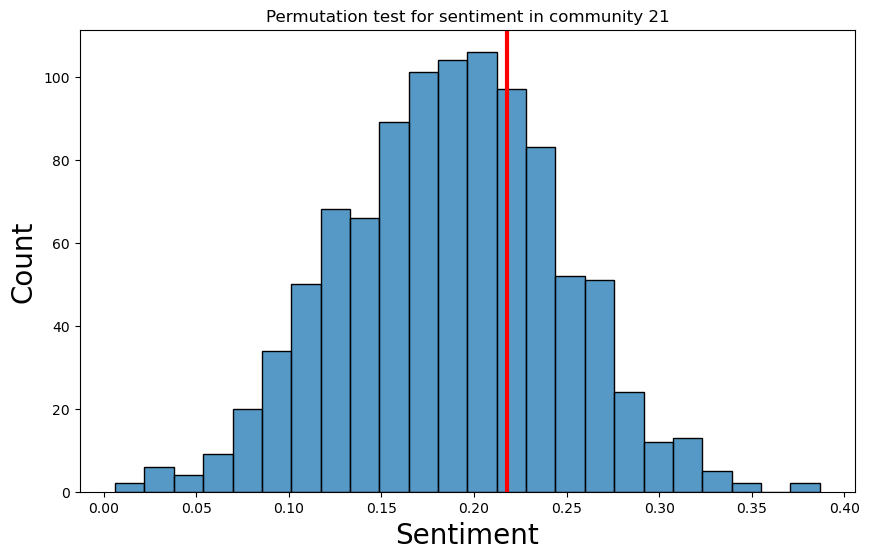

In [235]:
plt.figure(figsize=(10,6))
sns.histplot(data = sentiment_permutated_df, x = 21)
plt.axvline(community_mean.iloc[21].avg_lyrics_sentiment, 0,1, color = "red", linewidth = 3)
plt.xlabel("Sentiment", fontsize=20)
plt.ylabel("Count", fontsize=20)
plt.title("Permutation test for sentiment in community 21")
plt.show()

In [154]:
# Settings for the next plots
plt.rc('xtick', labelsize=10)    # fontsize of the tick labels
plt.rc('ytick', labelsize=10)    # fontsize of the tick labels

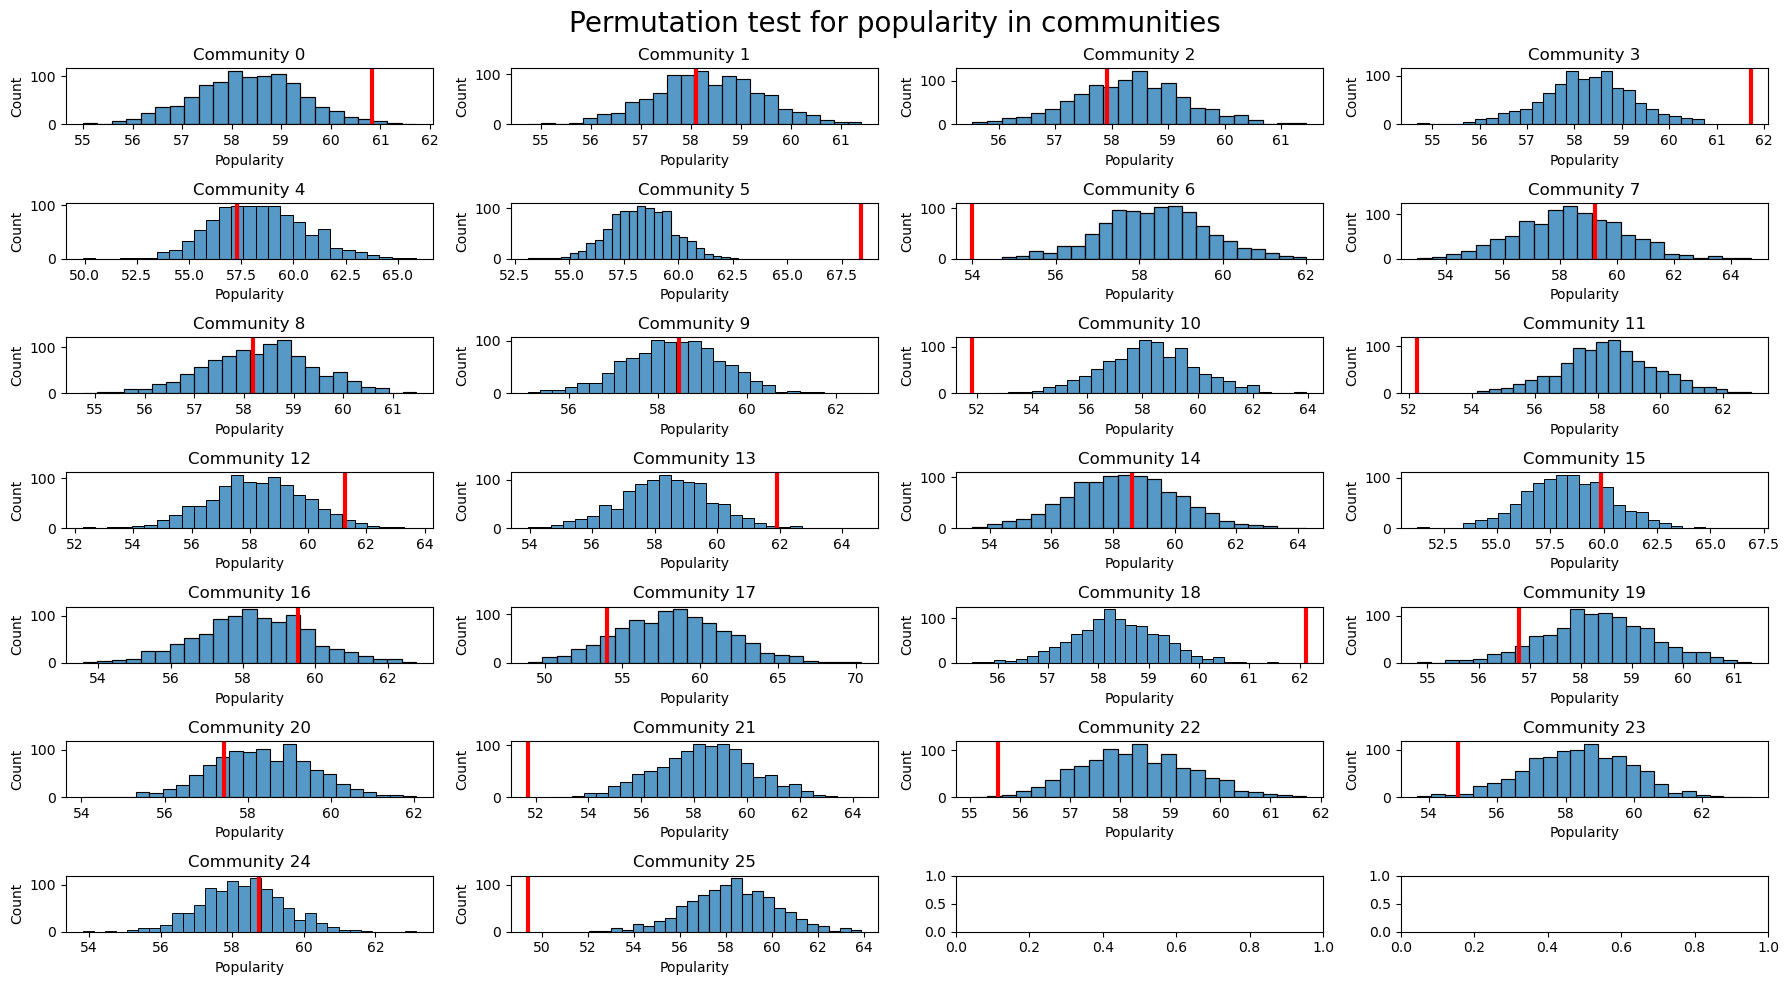

In [236]:
fig, axes = plt.subplots(7, 4, figsize=(18, 10))

i = 0
j = 0
for ind in range(0,np.shape(popularity_permutated_df)[1]):
    sns.histplot(ax=axes[i,j], data = popularity_permutated_df, x = ind)
    axes[i,j].axvline(community_mean.iloc[ind].popularity, 0,1, color = "red", linewidth = 3)
    axes[i,j].set_xlabel("Popularity")
    axes[i,j].set_title("Community " + str(ind))
    
    if j%3 == 0 and j != 0:
        j = 0
        i += 1
    else:
        j += 1
fig.suptitle("Permutation test for popularity in communities", fontsize=20) 
plt.tight_layout()

### TF

In [156]:
counter_dict = {}
word_dict = {}
for c in range(0, len(relations)):
    names = list(artist_df[artist_df.community_id == c].name.values) #names in each community
    index = track_lyrics[track_lyrics.artist_name.isin(names)].index.to_list() #index of songs in the communities
    word_list = [tokens_dict[key] for key in index] #all words in community(nested list)
    word_dict[c] = [word for words in word_list for word in words] #all words in the community
    print(c, ":", Counter(word_dict[c]).most_common(10))
    print("")
    counter_dict[c] = Counter(word_dict[c])

0 : [('im', 6397), ('like', 5525), ('nigga', 4608), ('got', 4320), ('yeah', 4209), ('feat', 3591), ('know', 3281), ('get', 3213), ('bitch', 2767), ('aint', 2535)]

1 : [('im', 5139), ('like', 5052), ('yeah', 3687), ('know', 3367), ('got', 2947), ('feat', 2677), ('love', 2397), ('get', 2292), ('bitch', 2111), ('baby', 1830)]

2 : [('im', 2833), ('like', 2322), ('love', 2104), ('know', 2011), ('yeah', 1707), ('got', 1677), ('oh', 1483), ('na', 1389), ('’', 1165), ('time', 1162)]

3 : [('im', 7160), ('like', 6279), ('feat', 6014), ('yeah', 5220), ('nigga', 4549), ('got', 4455), ('bitch', 3621), ('know', 3436), ('get', 3353), ('lil', 3017)]

4 : [('im', 1631), ('like', 1465), ('yeah', 1271), ('know', 1209), ('got', 1141), ('love', 928), ('girl', 921), ('get', 813), ('feat', 731), ('baby', 713)]

5 : [('like', 2693), ('want', 2575), ('know', 2162), ('baby', 2030), ('love', 1766), ('im', 1692), ('you', 1630), ('me', 1541), ('tell', 1423), ('yeah', 1364)]

6 : [('im', 2214), ('like', 1776), (

With this output we visualize for each community the most counted words. 

### TF-IDF

In [157]:
#tf-idf
def tf_idf(dictionary, corpus): #corpus needs to be a nested dictionary
    N = len(corpus.keys()) #number of documents
    count = 0
    tf = np.zeros(len(dictionary.keys())) #number of unique words in document
    idf = np.zeros(len(dictionary.keys())) 
    wordSum = sum(dictionary.values()) #number of words in total in the document
                  
    for word in dictionary.keys():
        tf[count] = dictionary[word]/wordSum
        
        wordDoc_count = 0
        for doc in corpus.keys():
            #tæl kun 1 gang hvis ordet er i 
            if word in corpus[doc]:
                wordDoc_count += 1
        idf[count] = math.log(N/wordDoc_count)
        count += 1
    
    return tf*idf

In [158]:
important_words = {}
for c in range(0, len(relations)):
    tf_idf_ = tf_idf(counter_dict[c], counter_dict)
    max_index = list(tf_idf_.argsort()[-10:]) #index for word with higest tf-idf
    wordList = list(counter_dict[0].keys()) #list with all words for the community
    important_words[c] = [wordList[j] for j in max_index]
    print(c, important_words[c])
    print("")

0 ['dipset', 'yoing', 'uoeno', 'dhis', 'curreny', 'soulja', 'feat', 'eryday', 'yuuuuuuu', 'bwok']

1 ['pressured', '123456', 'tank1', 'spike', 'laser', 'pepala', 'kite', 'nutsreload', 'roundsreload', 'runt']

2 ['wilson', 'jennifer', 'weenie', 'grazed', 'surprise', 'queen', 'instrument', 'regrets1', 'nananananana', 'choppas']

3 ['flex23', 'brigada', 'mile', 'introduce', 'complaint', 'kossisko', 'jocking', 'fivio', 'kota', 'klein']

4 ['pat', 'premonition', 'mediocre', 'bandit', 'pavin', 'remedy', 'weighin', 'glued', 'rabbit', 'pyrex']

5 ['na', 'hitting', 'pint', 'delong', 'way', 'haitian', 'cruisecruz', 'smino', 'mutherfuckin', 'earthgang']

6 ['hubby', 'vest', 'unaccommodating188', 'lamborghini', 'boujee', 'lolahol', 'bokeem', 'tap', 'flyin', 'bjork—venus']

7 ['chattin', 'exgirls', 'sorcerer', 'rascal', 'narcissist', 'skippin', 'swimmin', 'outfit', 'stunt', 'hangin']

8 ['sample', 'oneanddone', 'attest', 'aviator', 'lead', 'adjacent', 'wondering', 'pond', 'ponder', 'redveil']

9 ['

Through this output we can see the most important words in each community. Note that this list also includes a lot of slang words. We are using TF-IDF to optain this lists.

### Topic modelling

In [243]:
# Settings for the next plots
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels

In [244]:
#assign unique id
id_dict = Dictionary(list(word_dict.values()))

In [245]:
#filtering of the id dit
id_dict.filter_extremes(no_below=5, no_above=0.5)

In [246]:
#corpus of all communities
corpus = [id_dict.doc2bow(doc) for doc in list(word_dict.values())]

In [247]:
topics = []
score_umass = []
for i in range(1,20,1):
    lda_model = LdaMulticore(corpus=corpus, id2word=id_dict, iterations=50, num_topics=i, workers = 2, passes=50, random_state=35)
    cm_umass = CoherenceModel(model=lda_model, corpus=corpus, dictionary=id_dict, coherence='u_mass')
    topics.append(i)
    score_umass.append(cm_umass.get_coherence())

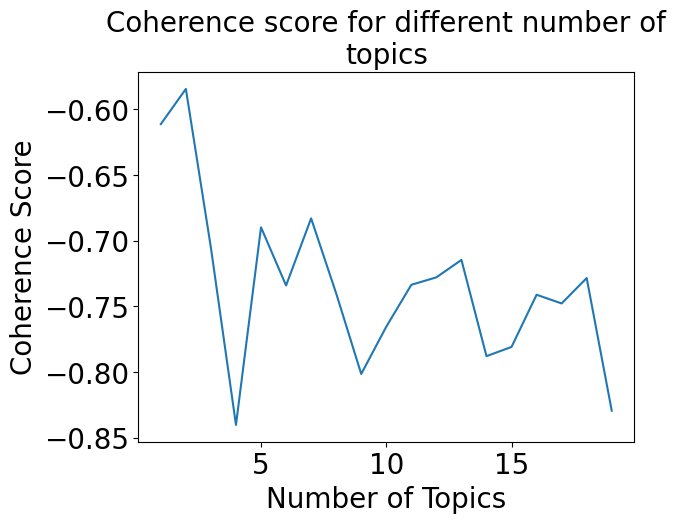

In [252]:
plt.plot(topics, score_umass)
plt.xlabel('Number of Topics', fontsize=20)
plt.ylabel('Coherence Score', fontsize=20)
plt.title("\n".join(wrap("Coherence score for different number of topics", 40)), fontsize=20)
plt.show()

In [254]:
lda_model = LdaMulticore(corpus=corpus, id2word=id_dict, iterations=100, num_topics=7, workers = 2, passes=100)

In [255]:
lda_model.print_topics()

[(0,
  '0.007*"tang" + 0.004*"geronimo" + 0.003*"ridiculous" + 0.003*"gnashin" + 0.003*"bambi" + 0.003*"ooooookay" + 0.003*"iiiiim" + 0.003*"twoseat" + 0.002*"ion" + 0.002*"jung"'),
 (1,
  '0.000*"precar" + 0.000*"shinedown" + 0.000*"perreo" + 0.000*"ere" + 0.000*"like1embed" + 0.000*"•" + 0.000*"tá" + 0.000*"vamo" + 0.000*"renounce" + 0.000*"thirtythree"'),
 (2,
  '0.006*"•" + 0.003*"remastered" + 0.002*"bio" + 0.002*"meta" + 0.002*"affair" + 0.002*"remaster" + 0.002*"heather" + 0.002*"rubberband" + 0.002*"shinedown" + 0.001*"bap"'),
 (3,
  '0.015*"precar" + 0.013*"yi" + 0.011*"vamo" + 0.010*"ere" + 0.009*"toa" + 0.009*"eheh" + 0.008*"tá" + 0.008*"uah" + 0.007*"perreo" + 0.006*"woh"'),
 (4,
  '0.005*"dum" + 0.005*"pus" + 0.004*"immaterial" + 0.003*"chitty" + 0.003*"cork" + 0.003*"percocets" + 0.002*"dodododo" + 0.002*"leo" + 0.002*"yawk" + 0.002*"buggin"'),
 (5,
  '0.002*"grizzley" + 0.002*"playboi" + 0.002*"bish" + 0.002*"getcha" + 0.002*"headie" + 0.002*"shiesty" + 0.001*"soulja" + 

In [256]:
for c in range(0,len(relations)):
    print(lda_model[corpus][c])

[(2, 0.18658145), (5, 0.8133841)]
[(5, 0.9908814)]
[(2, 0.9999001)]
[(5, 0.99996704)]
[(2, 0.39862692), (5, 0.5918005)]
[(3, 0.9999389)]
[(2, 0.9998693)]
[(2, 0.9997051)]
[(4, 0.999879)]
[(0, 0.99989736)]
[(2, 0.62017864), (5, 0.37972063)]
[(2, 0.99979925)]
[(3, 0.99981165)]
[(5, 0.99144113)]
[(2, 0.7059023), (5, 0.2940139)]
[(0, 0.35092244), (2, 0.16628613), (3, 0.010056243), (5, 0.47259805)]
[(3, 0.9999197)]
[(2, 0.4790411), (5, 0.5196538)]
[(2, 0.11158556), (3, 0.013844378), (5, 0.87409407)]
[(2, 0.69647104), (3, 0.038980134), (5, 0.26449034)]
[(4, 0.99990845)]
[(2, 0.9996923)]
[(5, 0.41490737), (6, 0.5850351)]
[(6, 0.99980646)]
[(2, 0.25248045), (5, 0.7380109)]
[(0, 0.99975175)]
